In [1]:
import numpy as np
from uncertainties import ufloat, unumpy
from uncertainties.umath import *
from astropy.io import fits
from astropy.table import Table
import pandas
import matplotlib.pyplot as plt
from astropy.stats import LombScargle
from scipy.ndimage.filters import gaussian_filter
from scipy import signal
from importlib import reload as reload
import warnings
warnings.filterwarnings("ignore")

# Changing Dir to One With Module

In [2]:
pwd

'/Users/lenatreiber/Desktop/RXJ0529'

In [3]:
cd ../Yale/ 

/Users/lenatreiber/Desktop/Yale


In [4]:
#import hardnessratios as h
import pulsations as p
import pulsations_gv as pgv

In [5]:
#set path to .evt files; where images should be saved
path = 'LXP_69_NICER/'

In [6]:
def sf(filename):
    '''
    Saves figure in LXP_69_NICER/0.3-8.0Figs/
    '''
    plt.savefig('LXP_69_NICER/0.3-8.0Figs/'+filename+'.png',dpi=200,bbox_inches='tight')

# Load in Data and Filter for Energy 
- hard+soft, soft, hard
- now hard+soft doesn't include all events
- also only gti, without high bg now

In [7]:
ed = p.readevt(path+'rxj0529_gti_bary.evt')

In [620]:
edtest = p.readevt(path+'rxj0529_gti_bary.evt',ind=2)

In [622]:
np.sum(edtest['STOP']-edtest['START'])

10174.024798244238

In [8]:
#energy filtering
ed = ed[ed['PI']>=30]
ed = ed[ed['PI']<=800] #this notebook: only up to 800 = 8 keV

In [9]:
len(ed)

60203

In [10]:
soft_evt = ed[ed['PI']<=150]
hard_evt = ed[ed['PI']>150]

# Find Exposure Time for These Events -- 6751 s
- **to do: clarify why separate files needed; true for other epochs/data too?**

In [11]:
gti_list = fits.open(path+'kgfilt2.gti', memmap=True)

In [629]:
e1path

'NIC_3ep/epoch1/'

In [12]:
tab1 = Table(gti_list[1].data)

In [625]:
tab1[:5]

START,STOP,DT
float64,float64,float64
203439227.0,203439630.0,403.0
203439632.0,203439653.0,21.0
203439655.0,203439681.0,26.0
203444913.0,203445007.0,94.0
203445009.0,203445027.0,18.0


In [626]:
edtest[:5]

START,STOP
float64,float64
203438657.2046231,203438658.20463592
203438662.204687,203438678.20488957
203438680.2049147,203438681.20492724
203438683.20495227,203438684.2049648
203438687.20500222,203438690.20503956


In [13]:
exptime = np.sum(tab1['STOP']-tab1['START']) #check
exptime

6751.0

# Frequency Search With These Data (HENDRICS)
.014 to .015 for gti, only these energies
oversample=50
f 0.01455985213471527
pd about 68.682

updated from: 0.014559697522140093 (and one with finer search)

In [14]:
f = 0.01455985213471527
pd = 1/f
pd

68.68201618721699

In [15]:
pd

68.68201618721699

# Average Count Rate of Total, Soft, Hard (Before Bg-Sub)


In [16]:
print('avg soft count rate: ',len(soft_evt)/exptime)
print('avg hard count rate: ',len(hard_evt)/exptime) 
print('avg count rate: ',len(ed)/exptime) 
print((len(soft_evt)/exptime)+(len(hard_evt)/exptime))

avg soft count rate:  4.484965190342171
avg hard count rate:  4.432676640497704
avg count rate:  8.917641830839875
8.917641830839875


# Calculate How Much Background to Subtract

Georgios: "For the 0.3-1.5: good counts are 91.4 %, so background is 8.6% of counts.
for 1.5-10.0 keV, good counts are 91.9% so BG is 8.1% of counts
So if the average count rate is 10 c/s you subtract 0.83 from all bins of the PP."

In [17]:
#how much to subtract from each soft bin
ssub = .086*len(soft_evt)/exptime #avg rate * percentage that's BG
hsub = .081*len(hard_evt)/exptime
tsub = .083*len(ed)/exptime
print(ssub,hsub,tsub)

0.38570700636942673 0.35904680788031407 0.7401642719597097


# Frequency Search Stingray

In [18]:
#checking if nans b/c of gti file -- yes!
eds = p.readevt('LXP_69_NICER/rxj0529_bary.evt')
eds = eds[eds['PI']>=30]
eds = eds[eds['PI']<=800] #constrain to 0.3 to 8.0 keV

In [19]:
df_min = 1/(eds['TIME'].max() - eds['TIME'].min())
oversampling=1
df = df_min / oversampling
frequencies = np.arange(.0146 - 200 * df, .0146 + 200 * df, df)

In [20]:
from stingray.pulse.search import epoch_folding_search, z_n_search
nbin=32
df_min = 1/exptime
oversampling=10
df = df_min / oversampling
frequencies = np.arange(1/pd - 200 * df, 1/pd + 200 * df, df)

freq, efstat = epoch_folding_search(eds['TIME'], frequencies, nbin=nbin)

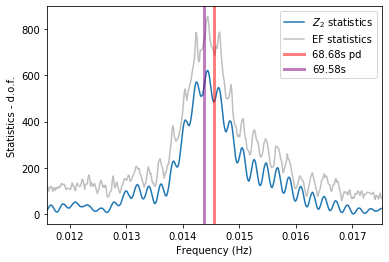

In [21]:

nharm = 1 
nbin = 32
freq, zstat = z_n_search(eds['TIME'], frequencies, nbin=nbin, nharm=nharm)

# ---- PLOTTING --------
plt.figure()
plt.plot(freq, (zstat - nharm), label='$Z_2$ statistics')
plt.plot(freq, efstat - nbin + 1, color='gray', label='EF statistics', alpha=0.5)

plt.axvline(1/pd, color='r', lw=3, alpha=0.5, label='68.68s pd')
plt.axvline(1/69.58, color='purple', lw=3, alpha=0.5, label='69.58s')

plt.xlim([frequencies[0], frequencies[-1]])
plt.xlabel('Frequency (Hz)')
plt.ylabel('Statistics - d.o.f.')
plt.legend()
#plt.figure(figsize=(15, 5))
#plt.plot(freq, (zstat - nharm), label='$Z_2$ statistics')
#plt.plot(freq, efstat - nbin + 1, color='gray', label='EF statistics', alpha=0.5)

In [22]:
df

1.4812620352540363e-05

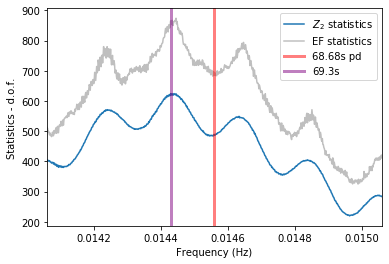

In [23]:
#finer search
frequencies = np.arange(1/pd - .0005, 1/pd + .0005, df/10)
freq, zstat = z_n_search(eds['TIME'], frequencies, nbin=nbin, nharm=nharm)
freqe, efstat = epoch_folding_search(eds['TIME'], frequencies, nbin=nbin)
# ---- PLOTTING --------
plt.figure()
plt.plot(freq, (zstat - nharm), label='$Z_2$ statistics')
plt.plot(freqe, efstat - nbin + 1, color='gray', label='EF statistics', alpha=0.5)

plt.axvline(1/pd, color='r', lw=3, alpha=0.5, label='68.68s pd')
plt.axvline(.01443, color='purple', lw=3, alpha=0.5, label='69.3s')

plt.xlim([frequencies[0], frequencies[-1]])
plt.xlabel('Frequency (Hz)')
plt.ylabel('Statistics - d.o.f.')
plt.legend()

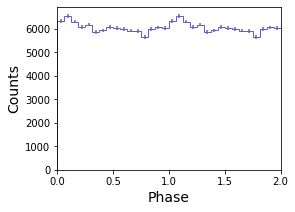

In [24]:
#what happens if we fold with this result?
stingh,stingm = p.phasehist(eds,69.3,bins=32,figsize=(4,3)) 

# 0.3-7.5 keV to Compare to 2003 Paper
they give period of 69.232 s


In [25]:
ppd = 69.232 #paper period

In [26]:
paper = ed[ed['PI']<=750] #to compare to paper

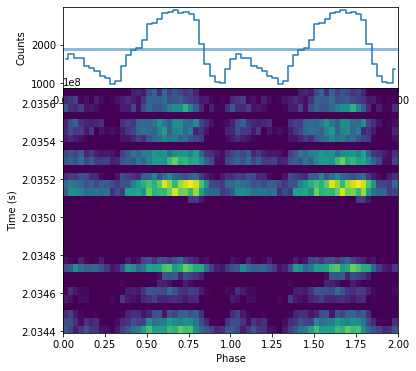

In [27]:
p.stingphase(paper,f,figsize=(6,6)) #and 1/ppd clearly doesn't work
#sf('.3-7.5stingphase')

In [28]:
bg=[tsub,ssub,hsub] #background argument,subtracting once y-axis is counts/s

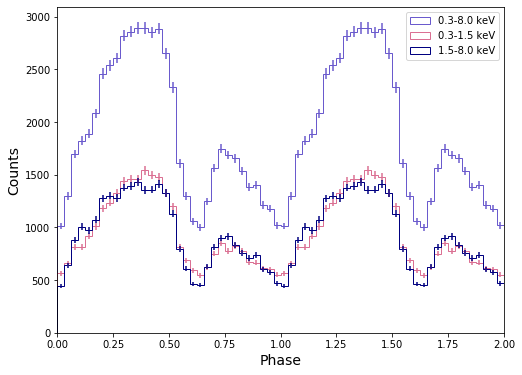

In [29]:
#32 phase bins; moved by 10 seconds
#reload(p)
hists3,mids3 = p.phasehist_sh([ed,soft_evt,hard_evt],pd,ens=['0.3-8.0 keV','0.3-1.5 keV','1.5-8.0 keV'],
                              bins=64,epoch=10)
#sf('countsphase')

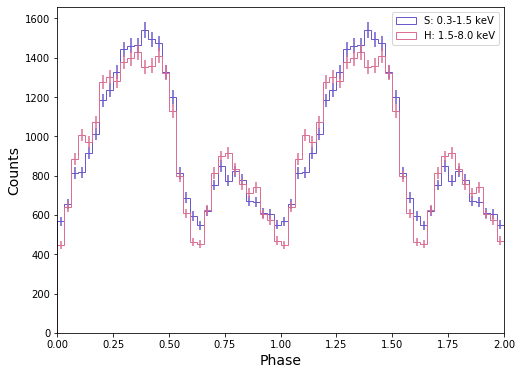

In [30]:
#for presentation
histsp,midsp = p.phasehist_sh([soft_evt,hard_evt],pd,ens=['S: 0.3-1.5 keV','H: 1.5-8.0 keV'],
                              bins=64,epoch=10)

> The plot above shows 32 phase bins, but 64 total thanks to the repeat of the phase. An interesting comparison can be made between this plot and the same one with an upper limit of 10 rather than 8 keV. We see that while the harder band has a higher count rate than the soft at the smaller peak, the soft's count rate exceeds the hard in the primary peak, which wasn't the case for the larger band. Otherwise, we still see the ascents are harder than the descents, where the relative relationship flips.

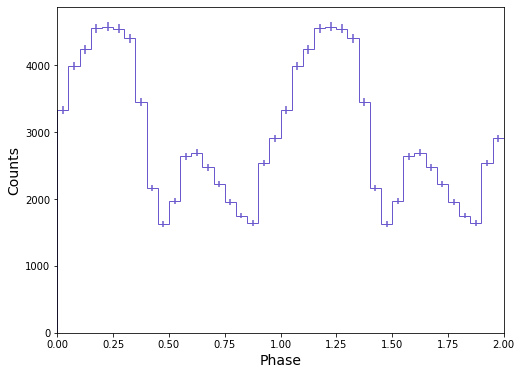

In [31]:
#bins to match paper
reload(p)
paphist3,pmids3 = p.phasehist(paper,pd,bins=40) 

# Counts/s Hists; BG-Subtract

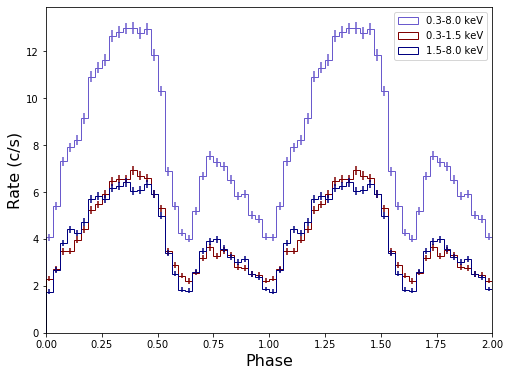

In [32]:
#convert to count rate and subtract background
reload(p)
ratehbg,bgerrs = p.phaserate(hists3,mids3,exptime,ens=['0.3-8.0 keV','0.3-1.5 keV','1.5-8.0 keV'],
                             bgb=True,bg=bg)
#plt.savefig('LXP_69_NICER/64bgsub.png',dpi=200,bbox_inches='tight')
#sf('bgsubcrphase')

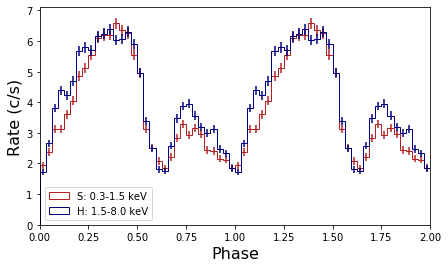

In [33]:
presr,prese = p.phaserate(histsp,midsp,exptime,ens=['S: 0.3-1.5 keV','H: 1.5-8.0 keV'],colors=['firebrick','navy'],figsize=(7,4),bgb=True,bg=bg)
#sf('prespp')

shift phase?

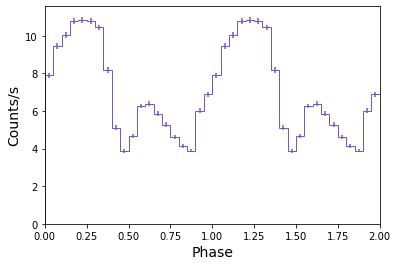

In [34]:
pcr,pcrerr = p.s_phaserate(paphist3,pmids3,exptime)
#sf('.3-7.5cr')

# Hardness Ratio

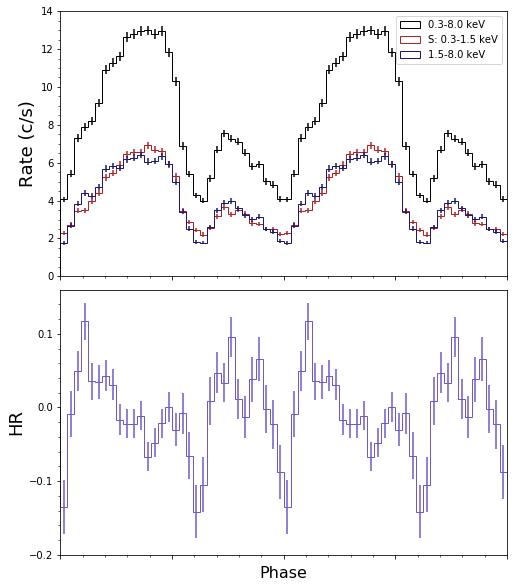

In [35]:
reload(p)
#background-subtracted, 32 phase bins (16 in "final" notebook)
rateh,rateherr = p.phaserate(hists3,mids3,exptime,ens=['0.3-8.0 keV','S: 0.3-1.5 keV','1.5-8.0 keV'],colors=['black','firebrick','midnightblue'],
                             rate=True,figsize=(8,10),bgb=True,bg=bg,yrange2=[-.2,.16])
#plt.yticks(np.arange(-.08,.12,.02))
#plt.savefig('LXP_69_NICER/newcountshr.png',dpi=200,bbox_inches='tight')
#sf('bgsubcrphasehr')

#where did x-axis tick labels go?

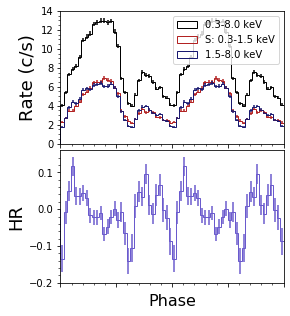

In [36]:
reload(p)
#background-subtracted, 32 phase bins (16 in "final" notebook)
hrs, rateh,rateherr = p.phaserate(hists3,mids3,exptime,ens=['0.3-8.0 keV','S: 0.3-1.5 keV','1.5-8.0 keV'],colors=['black','firebrick','midnightblue'],
                             rate=True,figsize=(4,5),bgb=True,bg=bg,yrange2=[-.2,.16],rethr=True)

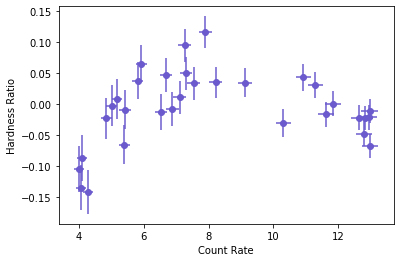

In [37]:
#rateh gives binning and values for three energy bands
#want to compare rate to HR, without phase
hr_c = pandas.DataFrame(columns=['count rate','HR','count rate err', 'HR err','phase'])
hr_c['count rate'] = rateh[0][0][:32]
hr_c['count rate err'] = rateherr[0][:32]
hr_c['HR'] = hrs[0][:32]
hr_c['HR err'] = hrs[1][:32]
hr_c['phase'] = rateh[0][1][:32]
plt.errorbar(hr_c['count rate'],hr_c['HR'],xerr=hr_c['count rate err'],yerr=hr_c['HR err'],linestyle='none',marker='o',color='slateblue')
plt.xlabel('Count Rate')
plt.ylabel('Hardness Ratio')
sf('hrcr')

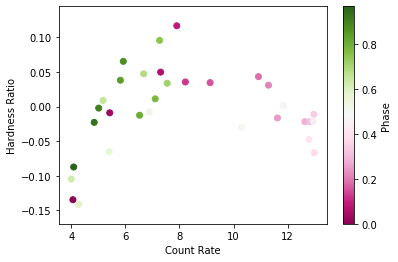

In [38]:
#rateh gives binning and values for three energy bands
#want to compare rate to HR, without phase
# hr_c = pandas.DataFrame(columns=['count rate','HR','count rate err', 'HR err','phase'])
# hr_c['count rate'] = rateh[0][0][:32]
# hr_c['count rate err'] = rateherr[0][:32]
# hr_c['HR'] = hrs[0][:32]
# hr_c['HR err'] = hrs[1][:32]
# hr_c['phase'] = rateh[0][1][:32]
# plt.errorbar(hr_c['count rate'],hr_c['HR'],xerr=hr_c['count rate err'],yerr=hr_c['HR err'],linestyle='none',marker='o',color='slateblue')
plt.scatter(hr_c['count rate'],hr_c['HR'],c=hr_c['phase'],cmap='PiYG')
plt.colorbar(label='Phase')
plt.xlabel('Count Rate')
plt.ylabel('Hardness Ratio')
sf('hrcr_phase')

# Calculations for 32 Phase Bins
- adding uncertainty 

In [39]:
totrate32 = ratehbg[0][0] #32 phase bins, bg-subtracted
totrerr = bgerrs[0]
totbins32 = ratehbg[0][1]
softrate32 = ratehbg[1][0]
softrerr = bgerrs[1]
hardrate32 = ratehbg[2][0]
hardrerr = bgerrs[2]

In [40]:
hardrate32[:32]-hardrate32[32:]

array([ 1.19904087e-14,  9.32587341e-15, -1.24344979e-14,  1.24344979e-14,
       -7.10542736e-15, -3.55271368e-15, -1.06581410e-14, -7.10542736e-15,
        7.10542736e-15,  7.10542736e-15,  0.00000000e+00,  7.10542736e-15,
        0.00000000e+00,  1.42108547e-14,  0.00000000e+00,  1.42108547e-14,
        1.42108547e-14, -1.42108547e-14,  1.42108547e-14, -1.42108547e-14,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  1.42108547e-14,
        0.00000000e+00,  0.00000000e+00,  1.42108547e-14, -1.42108547e-14,
        1.42108547e-14, -1.42108547e-14,  2.84217094e-14, -2.84217094e-14])

In [41]:
print('min hardness ratio: ',np.min((hardrate32-softrate32)/(hardrate32+softrate32)))
print('max hardness ratio: ',np.max((hardrate32-softrate32)/(hardrate32+softrate32)))

min hardness ratio:  -0.1415472066126026
max hardness ratio:  0.11682980958621231


In [42]:
import scipy.stats as st

In [43]:
print('min soft rate: ',np.min(softrate32),np.min(softrerr))
print('max soft rate: ',np.max(softrate32), np.max(softrerr))
print('mean soft rate: ',np.mean(softrate32))
print('soft standard error', st.sem(softrate32))

print('min hard rate: ',np.min(hardrate32),np.min(hardrerr))
print('max hard rate: ',np.max(hardrate32),np.max(hardrerr))
print('mean hard rate: ',np.mean(hardrate32))
print('hard standard error', st.sem(hardrate32))


print('min total rate: ',np.min(totrate32),np.min(totrerr))
print('max total rate: ',np.max(totrate32),np.max(totrerr))
print('mean total rate: ',np.mean(totrate32))
print('total standard error', st.sem(totrate32))

min soft rate:  2.207094060139241 0.11086016828109851
max soft rate:  6.923432380388093 0.18613329145735433
mean soft rate:  4.099258183972745
soft standard error 0.20059449511997834
min hard rate:  1.7550103688342347 0.10010350860941668
max hard rate:  6.40972818841653 0.17912078094685763
mean hard rate:  4.073629832617389
hard standard error 0.19556802878399007
min total rate:  3.9998742408532166 0.14989317897406035
max total rate:  12.982247222633703 0.25503874014164857
mean total rate:  8.177477558880165
total standard error 0.3930688714577073


> **pulsed fraction is further down**

# Compare to Paper
> load in extracted data from 2003 paper pulse profile

In [44]:
papdata = pandas.read_csv(path+'2003PP.csv',names=['Phase','Int']) #normalized intensity

In [45]:
papdata[:5] 

,Phase,Int
0,0.0025,0.395561
1,0.0525,0.839426
2,0.1025,1.283290
3,0.1500,1.186684
4,0.2025,1.332898


In [46]:
(papdata['Phase'][1]-papdata['Phase'][0])*(2/3)

0.03333333333333336

## error updated later; just approximated here

Text(0, 0.5, 'Counts/s')

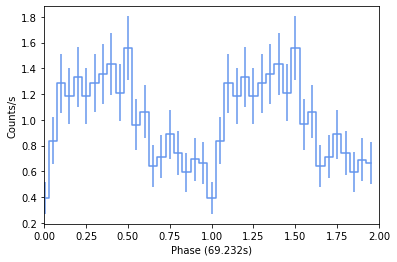

In [47]:
plt.step(papdata['Phase'],papdata['Int'],where='mid',color='cornflowerblue')
plt.xlim(0,2) #no error; 69.3 second phase
plt.errorbar(papdata['Phase'],papdata['Int'],yerr=np.sqrt(papdata['Int'])*.2,linestyle='none',color='cornflowerblue')
plt.xlabel('Phase (69.232s)')
plt.ylabel('Counts/s')
#sf('papapproxerr')

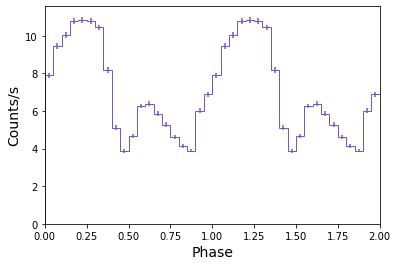

In [48]:
p3,p3err = p.s_phaserate(paphist3,pmids3,exptime) #same number of bins (20 phase)

In [49]:
(papdata['Int'].max()-papdata['Int'].min())/(papdata['Int'].max()+papdata['Int'].min())

0.5943775100401607

In [50]:
(p3[0].max()-p3[0].min())/(p3[0].max()+p3[0].min())

0.4748711340206183

In [51]:
papdata['Int'].max()/np.median(papdata['Int'])

1.5347938144329896

In [52]:
np.mean(p3[0]) - p3[0].min()

3.209124574137162

In [53]:
#simple pulsed fraction
print(papdata['Int'].max()/np.median(papdata['Int']))
print(paphist3[0].max()/np.median(paphist3[0]))

1.5347938144329896
1.7178236397748592


# Shift Phase, Compare to 2003 Paper
moved to module
s_phaserate now returns error as well
different bins here

In [54]:
np.mean(p3[0])/papdata['Int'].mean()

7.063956274550847

> - paper errors not exact right now
- two profiles phase-folded with different periods
- scaled based on means
- how do you adjust the error when you scale up like this?

Text(0, 0.5, 'Counts/s (0.3-7.5 keV)')

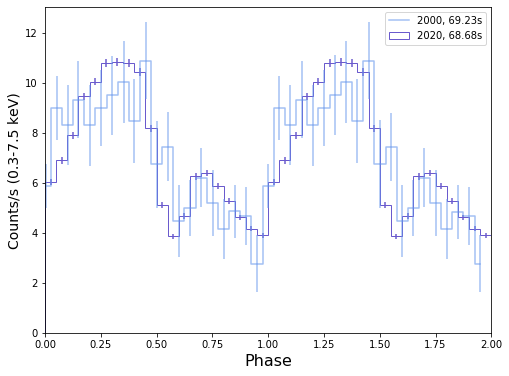

In [55]:
reload(p) #now in module
mod = p.phaseroll(p3[1],p3[0],2,pmids3,p3err,label='2020, 68.68s')
#plt.savefig(path+'shiftedpp.png',dpi=200,bbox_inches='tight')
paproll = np.roll(papdata['Int'],-1)
#paproll=papdata['Int']
plt.step(papdata['Phase'],7*paproll,where='mid',color='cornflowerblue',alpha=.6,label='2000, 69.23s')
plt.errorbar(papdata['Phase'],7*paproll,yerr=7*np.sqrt(papdata['Int'])*.2,alpha=.6,linestyle='none',color='cornflowerblue')
plt.legend()
plt.ylabel('Counts/s (0.3-7.5 keV)')
#plt.savefig(path+'papdataandours.png',dpi=200,bbox_inches='tight')
#sf('0020cr')

# Overall Pulsed Fraction
rms first, then (max-min)/(max+min)

move these to module when done

In [56]:
#adding error propogation
def pferr(countrate,err): 
    totlen = len(countrate)
    r=countrate[:int(totlen/2)] #count rate in phase bins up to 1
    err=err[:int(totlen/2)]
    rerr=unumpy.uarray(r,err)
    avgr = np.mean(rerr)
    num = np.sum(((rerr-avgr)**2)/20)
    num = (num)**(1/2)
    full = num/avgr
    return full

In [57]:
pferr(ratehbg[0][0],bgerrs[0]) #32 phase bins

0.48259137621194753+/-0.005604424220667505

In [58]:
pferr(ratehbg[1][0],bgerrs[1])

0.49129687785711734+/-0.00819880113941875

In [59]:
pferr(ratehbg[2][0],bgerrs[2])

0.4819994713554963+/-0.007619190639884023

In [60]:
def pf2(countrate,err):
    totlen = len(countrate)
    r=countrate[:int(totlen/2)]
    err=err[:int(totlen/2)]
    rerr=unumpy.uarray(r,err)
    rmax = rerr.max()
    rmin = rerr.min()
    pf = (rmax-rmin)/(rmax+rmin)#count rate in phase bins up to 1
    return pf

In [61]:
pf2(ratehbg[0][0],bgerrs[0])

0.5289311468589708+/-0.015237073133604279

In [62]:
pf2(ratehbg[1][0],bgerrs[1]) #soft

0.5165461543722839+/-0.020885122894565993

In [63]:
pf2(ratehbg[2][0],bgerrs[2]) #hard

0.5701000450833315+/-0.02143636832035671

# Pulsed Fraction as Function of Energy
> not bg-subtracted

In [64]:
#make tables for energies
en1 = ed[ed['PI']<=70]
en2 = ed[ed['PI']>70]
en2 = en2[en2['PI']<=100]
en3 = ed[ed['PI']>100]
en3 = en3[en3['PI']<=150]
en4 = ed[ed['PI']>150]
en4 = en4[en4['PI']<=200]
en5 = ed[ed['PI']>200]
en5 = en5[en5['PI']<=300]
en6 = ed[ed['PI']>300]
en6 = en6[en6['PI']<=500]
en7 = ed[ed['PI']>500]
en7 = en7[en7['PI']<=800]

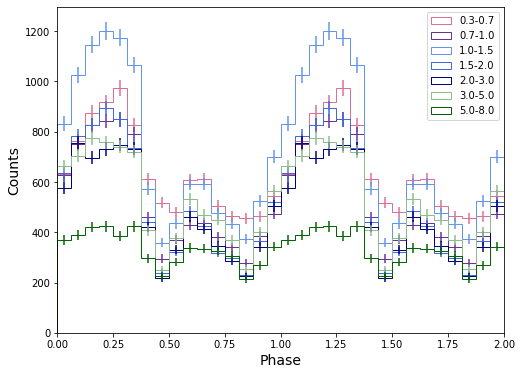

In [65]:
#up to 8.0 for now since higher energies filtered out
pfens,pfmids = p.phasehist_sh([en1,en2,en3,en4,en5,en6,en7],pd,ens=['0.3-0.7','0.7-1.0','1.0-1.5','1.5-2.0','2.0-3.0','3.0-5.0','5.0-8.0'],
               colors=['palevioletred','rebeccapurple','cornflowerblue','royalblue','navy','darkseagreen','darkgreen'])
#sf('pfcounts')

In [66]:
np.min(pfens[-1][0]) #minimum counts in a bin 5-8 keV 

214.0

In [67]:
pf = []
pfn = []
pfe = []
for i in range(7):
    cr = pfens[i][0]
    totlen = len(cr)
    r = cr[:int(totlen/2)]
    rerr = unumpy.uarray(r,np.sqrt(r))
    rmax = rerr.max()
    rmin = rerr.min()
    pf.append((rmax-rmin)/(rmax+rmin))
    pfn.append(((rmax-rmin)/(rmax+rmin)).n)
    pfe.append(((rmax-rmin)/(rmax+rmin)).s)
pfn

[0.3631910426871938,
 0.5079928952042628,
 0.5397435897435897,
 0.5893333333333334,
 0.551440329218107,
 0.5111976630963972,
 0.3281004709576138]

In [68]:
pfe

[0.024647156871649426,
 0.02566942494347982,
 0.021313846127586897,
 0.02408662555992843,
 0.026757437397518572,
 0.026818967354755575,
 0.03742811175284776]

Text(0, 0.5, 'Pulsed Fraction')

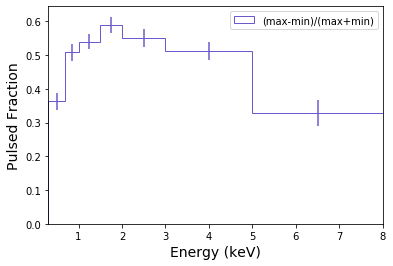

In [69]:
#plot as function of energy
enbins = [.3,.7,1,1.5,2,3,5,8]
plt.hist(enbins[:-1],enbins,weights=pfn,color='slateblue',histtype='step',label='(max-min)/(max+min)')
plt.xlim(.3,8)
plt.errorbar([.5,.85,1.25,1.75,2.5,4,6.5],pfn,yerr=pfe,linestyle='none',color='slateblue')
plt.legend()
plt.xlabel('Energy (keV)',fontsize=14)
plt.ylabel('Pulsed Fraction',fontsize=14)
#sf('pfenergy')

In [70]:
#how much to subtract from each soft bin
bg1 = .132*len(en1)/exptime #avg rate * percentage that's BG
bg2 = .068*len(en2)/exptime
bg3 = .058*len(en3)/exptime
bg4 = .055*len(en4)/exptime
bg5 = .064*len(en5)/exptime
bg6 = .075*len(en6)/exptime
bg7 = .143*len(en7)/exptime

pfbg = [bg1,bg2,bg3,bg4,bg5,bg6,bg7]
pfbg2 = 2*np.array(pfbg) #doubles each background value
pfbg

[0.20031699007554438,
 0.0859392682565546,
 0.0988087690712487,
 0.06810842838098059,
 0.073830839875574,
 0.09369723003999407,
 0.11317567767738113]

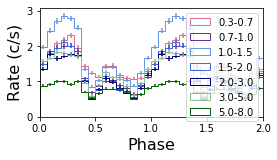

In [71]:
pfcr_ns,pfcrerr_ns = p.phaserate(pfens,pfmids,exptime,ens=['0.3-0.7','0.7-1.0','1.0-1.5','1.5-2.0','2.0-3.0','3.0-5.0','5.0-8.0'],
               colors=['palevioletred','rebeccapurple','cornflowerblue','royalblue','navy','darkseagreen','darkgreen'],
                           rate=False,figsize=(4,2))

In [72]:
bg7

0.11317567767738113

In [73]:
np.min(pfcr_ns[-1][0])

0.5071841208709813

In [74]:
#calculating error as 80% of min in hardest bin
bgguess = 0.8*np.min(pfcr_ns[-1][0])/bg7

bg1_g = bgguess*.132*len(en1)/exptime #avg rate * percentage that's BG
bg2_g = bgguess*.068*len(en2)/exptime
bg3_g = bgguess*.058*len(en3)/exptime
bg4_g = bgguess*.055*len(en4)/exptime
bg5_g = bgguess*.064*len(en5)/exptime
bg6_g = bgguess*.075*len(en6)/exptime
bg7_g = bgguess*.143*len(en7)/exptime
pfbg_g = [bg1_g,bg2_g,bg3_g,bg4_g,bg5_g,bg6_g,bg7_g]

In [75]:
pfbg_g

[0.7181585202191618,
 0.3081017625942236,
 0.35424034353812917,
 0.24417623348918951,
 0.2646917103316305,
 0.3359149119042776,
 0.40574729669678505]

In [76]:
pfbg

[0.20031699007554438,
 0.0859392682565546,
 0.0988087690712487,
 0.06810842838098059,
 0.073830839875574,
 0.09369723003999407,
 0.11317567767738113]

- minimum count rate in hardest bin is .5096...
- 

If I recall correctly the BG at 5.0-8.0 is about 0.1 c/s, or lets say X?
The minimum in the pulse profile in the 5.0-8.0 keV band is about 0.5 c/s (or just Y), so it is reasonable to say that BG cannot be higher than that.
So lets say that BG contribution in the 5.0-8.0 keV is about 80.0% of that minimum, i.e 0.8*Y

Then we can scale the NICER BG by Z=0.8*Y/X, so we can scale the BG in all energy bands by this Z value in a similar way that you did before for Z=2, see plot below:

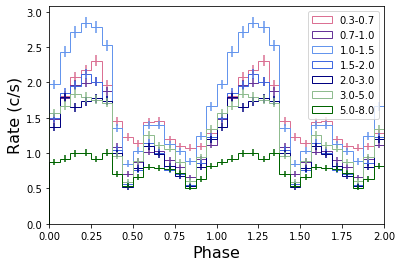

In [633]:
#no bg-subtraction
pfcr_nb,pfcrerr_nb = p.phaserate(pfens,pfmids,exptime,ens=['0.3-0.7','0.7-1.0','1.0-1.5','1.5-2.0','2.0-3.0','3.0-5.0','5.0-8.0'],
               colors=['palevioletred','rebeccapurple','cornflowerblue','royalblue','navy','darkseagreen','darkgreen'],
                           rate=False,figsize=(6,4),bgb=False)

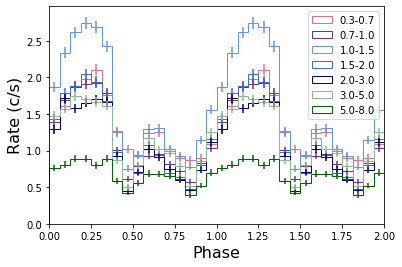

In [77]:
#make bg-subtracted count rate hist
reload(p)
pfcr,pfcrerr = p.phaserate(pfens,pfmids,exptime,ens=['0.3-0.7','0.7-1.0','1.0-1.5','1.5-2.0','2.0-3.0','3.0-5.0','5.0-8.0'],
               colors=['palevioletred','rebeccapurple','cornflowerblue','royalblue','navy','darkseagreen','darkgreen'],
                           rate=False,figsize=(6,4),bgb=True,bg=pfbg)
#sf('pfcr')


In [78]:
pfbg2

array([0.40063398, 0.17187854, 0.19761754, 0.13621686, 0.14766168,
       0.18739446, 0.22635136])

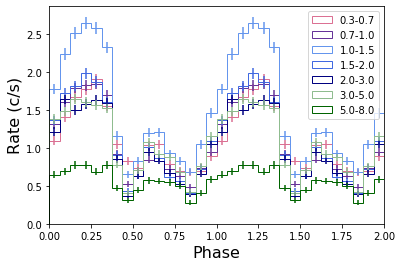

In [79]:
#count rate hist with doubled background
pfcr2,pfcrerr2 = p.phaserate(pfens,pfmids,exptime,ens=['0.3-0.7','0.7-1.0','1.0-1.5','1.5-2.0','2.0-3.0','3.0-5.0','5.0-8.0'],
               colors=['palevioletred','rebeccapurple','cornflowerblue','royalblue','navy','darkseagreen','darkgreen'],
                           rate=False,figsize=(6,4),bgb=True,bg=pfbg2)

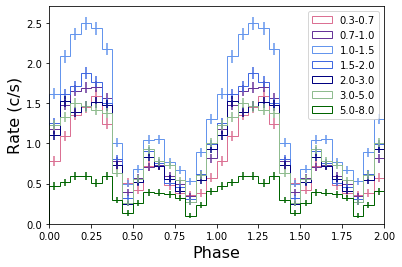

In [80]:
#.8 scaling
pfcrg,pfcrerrg = p.phaserate(pfens,pfmids,exptime,ens=['0.3-0.7','0.7-1.0','1.0-1.5','1.5-2.0','2.0-3.0','3.0-5.0','5.0-8.0'],
               colors=['palevioletred','rebeccapurple','cornflowerblue','royalblue','navy','darkseagreen','darkgreen'],
                           rate=False,figsize=(6,4),bgb=True,bg=pfbg_g)

In [81]:
(np.max(pfcrg[-1][0])-np.min(pfcrg[-1][0]))/(np.max(pfcrg[-1][0])+np.min(pfcrg[-1][0]))

0.7094365241004742

In [634]:
#no bg-subtraction
pfr_nb = [] #adding r to variables (for rate)
pfnr_nb = []
pfer_nb = []
for i in range(7):
    cr = pfcr_nb[i][0]
    totlen = len(cr)
    r = cr[:int(totlen/2)] #first half of count rates, since second half just repeated
    e = pfcrerr_nb[i][:int(totlen/2)] #errors originally from sqrt of counts
    rerr = unumpy.uarray(r,e)
    rmax = rerr.max()
    rmin = rerr.min()
    pfr_nb.append((rmax-rmin)/(rmax+rmin))
    pfnr_nb.append(((rmax-rmin)/(rmax+rmin)).n) #value
    pfer_nb.append(((rmax-rmin)/(rmax+rmin)).s) #propogated error
pfnr_nb

[0.3631910426871945,
 0.5079928952042639,
 0.53974358974359,
 0.5893333333333334,
 0.5514403292181069,
 0.5111976630963969,
 0.3281004709576147]

In [82]:
#original bg-subtraction
pfr = [] #adding r to variables (for rate)
pfnr = []
pfer = []
for i in range(7):
    cr = pfcr[i][0]
    totlen = len(cr)
    r = cr[:int(totlen/2)] #first half of count rates, since second half just repeated
    e = pfcrerr[i][:int(totlen/2)] #errors originally from sqrt of counts
    rerr = unumpy.uarray(r,e)
    rmax = rerr.max()
    rmin = rerr.min()
    pfr.append((rmax-rmin)/(rmax+rmin))
    pfnr.append(((rmax-rmin)/(rmax+rmin)).n) #value
    pfer.append(((rmax-rmin)/(rmax+rmin)).s) #propogated error
pfnr

[0.41191865598641175,
 0.5429634031275452,
 0.5702220496807653,
 0.6210627385775513,
 0.58920782327283,
 0.5538376332671806,
 0.38596927804585096]

In [83]:
#guess with 0.8
pfrg = [] #adding r to variables (for rate)
pfnrg = []
pferg = []
for i in range(7):
    cr = pfcrg[i][0]
    totlen = len(cr)
    r = cr[:int(totlen/2)] #first half of count rates, since second half just repeated
    e = pfcrerrg[i][:int(totlen/2)] #errors originally from sqrt of counts
    rerr = unumpy.uarray(r,e)
    rmax = rerr.max()
    rmin = rerr.min()
    pfrg.append((rmax-rmin)/(rmax+rmin))
    pfnrg.append(((rmax-rmin)/(rmax+rmin)).n) #value
    pferg.append(((rmax-rmin)/(rmax+rmin)).s) #propogated error
pfnrg

[0.6306472863955419,
 0.6605076063773347,
 0.6676893838374379,
 0.7214789095655566,
 0.7159713737175235,
 0.7060913999353012,
 0.7094365241004742]

In [84]:
pfr2 = [] #adding r to variables (for rate)
pfnr2 = []
pfer2 = []
for i in range(7):
    cr = pfcr2[i][0]
    totlen = len(cr)
    r = cr[:int(totlen/2)]
    e = pfcrerr2[i][:int(totlen/2)]
    rerr = unumpy.uarray(r,e)
    rmax = rerr.max()
    rmin = rerr.min()
    pfr2.append((rmax-rmin)/(rmax+rmin))
    pfnr2.append(((rmax-rmin)/(rmax+rmin)).n)
    pfer2.append(((rmax-rmin)/(rmax+rmin)).s)
pfnr2

[0.47574742303479245,
 0.58310464485665,
 0.6043486546244339,
 0.6564031483589915,
 0.6325289830444463,
 0.6042383000762498,
 0.46862273683526007]

Text(0, 0.5, 'PF')

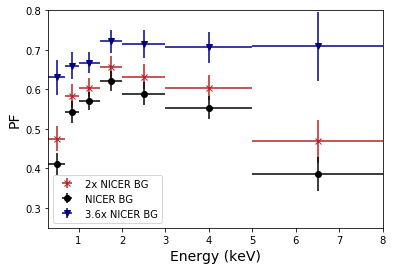

In [85]:
plt.errorbar([.5,.85,1.25,1.75,2.5,4,6.5],pfnr2,yerr=pfer2,xerr=[.2,.15,.25,.25,.5,1,1.5],marker='x',color='firebrick',linestyle='none',label='2x NICER BG')
plt.xlim(.3,8)
#plt.errorbar([.5,.85,1.25,1.75,2.5,4,6.5],pfnr,yerr=pfer,linestyle='none',color='slateblue')
#adding original
plt.errorbar([.5,.85,1.25,1.75,2.5,4,6.5],pfnr,yerr=pfer,xerr=[.2,.15,.25,.25,.5,1,1.5],marker='o',linestyle='none',color='black',label='NICER BG')
#guess with .8
plt.errorbar([.5,.85,1.25,1.75,2.5,4,6.5],pfnrg,yerr=pferg,xerr=[.2,.15,.25,.25,.5,1,1.5],marker='v',linestyle='none',color='navy',label='3.6x NICER BG')

plt.legend(loc = 'lower left')
plt.xlabel('Energy (keV)',fontsize=14)
plt.ylim(.25,.8)
plt.ylabel('PF',fontsize=14)
#sf('2bgpf')


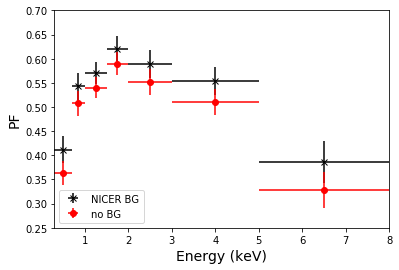

In [637]:
#version w/ no bg-subtraction and normal bg-subtraction
plt.xlim(.3,8)
#adding original
plt.errorbar([.5,.85,1.25,1.75,2.5,4,6.5],pfnr,yerr=pfer,xerr=[.2,.15,.25,.25,.5,1,1.5],marker='x',linestyle='none',color='black',label='NICER BG')
plt.errorbar([.5,.85,1.25,1.75,2.5,4,6.5],pfnr_nb,yerr=pfer_nb,xerr=[.2,.15,.25,.25,.5,1,1.5],marker='o',linestyle='none',color='red',label='no BG')

plt.legend(loc = 'lower left')
plt.xlabel('Energy (keV)',fontsize=14)
plt.ylim(.25,.7)
plt.ylabel('PF',fontsize=14)
#sf('PFep1_nb')

In [86]:
rms_pf = []
rms_pfe = []
for i in range(7):
    cr = pfcr[i][0]
    e = pfcrerr[i]
    rms_pf.append(pferr(cr,e).n)
    rms_pfe.append(pferr(cr,e).s)

In [87]:
rms_pf2 = []
rms_pfe2 = []
for i in range(7):
    cr = pfcr2[i][0]
    e = pfcrerr2[i]
    rms_pf2.append(pferr(cr,e).n)
    rms_pfe2.append(pferr(cr,e).s)

In [88]:
rms_pfe

[0.010724437848099906,
 0.010560389596154114,
 0.008942120315078296,
 0.010161524424013704,
 0.010424548028413758,
 0.00993069335843302,
 0.013669486986149544]

Text(0, 0.5, 'RMS Pulsed Fraction')

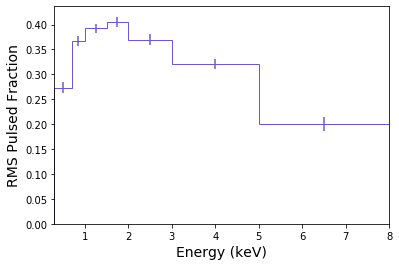

In [89]:
#rms pf vs energy hist
enbins = [.3,.7,1,1.5,2,3,5,8]
plt.hist(enbins[:-1],enbins,weights=rms_pf,color='slateblue',histtype='step')
plt.xlim(.3,8)
plt.errorbar([.5,.85,1.25,1.75,2.5,4,6.5],rms_pf,yerr=rms_pfe,linestyle='none',color='slateblue')
plt.xlabel('Energy (keV)',fontsize=14)
plt.ylabel('RMS Pulsed Fraction',fontsize=14)
#sf('rmspf')

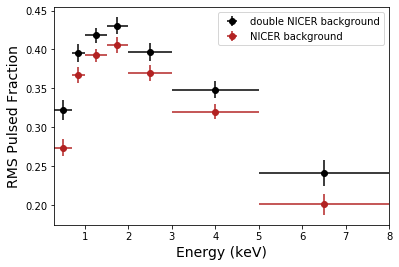

In [90]:
#double the background
plt.errorbar([.5,.85,1.25,1.75,2.5,4,6.5],rms_pf2,yerr=rms_pfe2,xerr=[.2,.15,.25,.25,.5,1,1.5],marker='o',color='black',linestyle='none',label='double NICER background')
plt.xlim(.3,8)
#plt.errorbar([.5,.85,1.25,1.75,2.5,4,6.5],pfnr,yerr=pfer,linestyle='none',color='slateblue')
#adding original background
plt.errorbar([.5,.85,1.25,1.75,2.5,4,6.5],rms_pf,yerr=rms_pfe,xerr=[.2,.15,.25,.25,.5,1,1.5],linestyle='none',marker='o',color='firebrick',label='NICER background')

plt.xlabel('Energy (keV)',fontsize=14)
plt.ylabel('RMS Pulsed Fraction',fontsize=14)
plt.legend()
#sf('2bgpfrms')

# 2D Histograms
- phase, time
- energy

Text(0, 0.5, 'Time (s)')

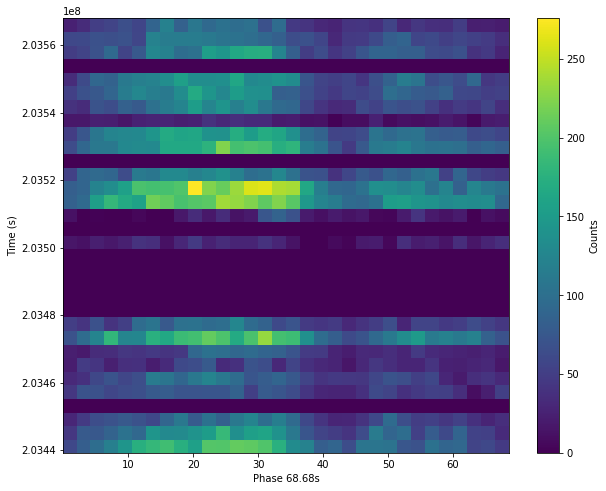

In [91]:
#added epoch of 10 seconds
ph = (ed['TIME']+10)%pd
plt.figure(figsize=(10,8)) 
hist = plt.hist2d(ph,ed['TIME'],bins=32)
plt.colorbar(label='Counts')
plt.xlabel('Phase 68.68s')
plt.ylabel('Time (s)')
#sf('simple2dhist')

Text(0, 0.5, 'Counts')

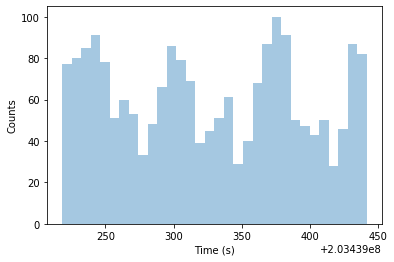

In [92]:
import seaborn as sb
sb.distplot(ed['TIME'][:2000],kde=False,bins=32)
plt.xlabel('Time (s)')
plt.ylabel('Counts')
#sf('timecountshist32b')

Text(0.5, 0, 'Phase (68.68s)')

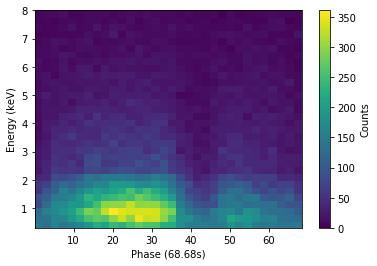

In [93]:
enhist1 = plt.hist2d(ph,ed['PI']/100,bins=32)
plt.colorbar(label='Counts')
plt.ylabel('Energy (keV)')
plt.xlabel('Phase (68.68s)')

In [94]:
enbg = np.loadtxt('LXP_69_NICER/BG_rate32.ascii')

In [95]:
enbg[:,1] #energy bin on left, count rate to subtract on right

array([0.12898389, 0.09495822, 0.06578335, 0.04942853, 0.04444942,
       0.03716503, 0.02883169, 0.02353626, 0.01784542, 0.01538645,
       0.01417338, 0.01287377, 0.01189645, 0.01129514, 0.01069084,
       0.01013578, 0.01017308, 0.00941062, 0.00916443, 0.00868248,
       0.00836914, 0.00811847, 0.00803491, 0.00773351, 0.00813787,
       0.00793644, 0.00756341, 0.00733662, 0.00740824, 0.00889287,
       0.00744703, 0.00731871])

Text(0.5, 0, 'Phase')

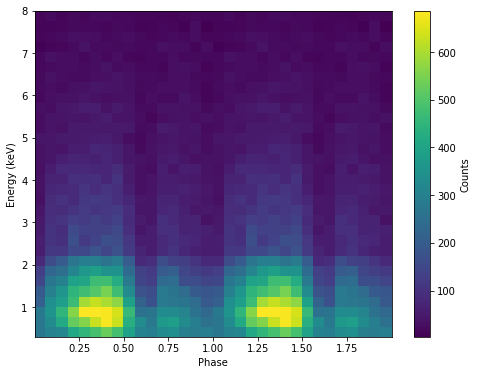

In [96]:
plt.figure(figsize=(8,6)) 
ph1 = ph/pd
ph2 = ph1 + 1
ph3 = list(ph1)+list(ph2)
ed2 = list(ed['PI'])+list(ed['PI'])
enhist = plt.hist2d(ph3,np.array(ed2)/100,bins=32) #convert from PI to keV
plt.colorbar(label='Counts')
plt.ylabel('Energy (keV)')
plt.xlabel('Phase')
#sf('enphase2d')

In [97]:
#version with each row normalized
norm = np.zeros((32,32))
for i in range(32):
    norm[i,:] = enhist[0][:,31-i]/np.median(enhist[0][:,31-i])

In [98]:
#version with each row normalized; bg-subtracted
#convert to count rate -- make sure corresponding
norm_bg = np.zeros((32,32)) #16 phase bins
for i in range(32):
    norm_bg[i,:] = ((enhist[0][:,31-i]*16/exptime)-enbg[31-i,1]) 
    norm_bg[i,:] = norm_bg[i,:]/np.median(norm_bg[i,:]) #16 phase bins

Text(0, 0.5, 'Energy (0.3-8.0 keV)')

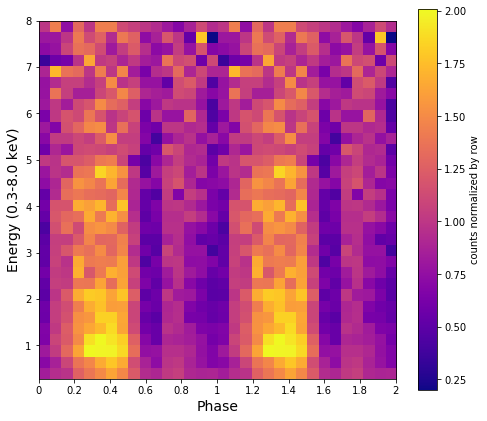

In [99]:
plt.figure(figsize=(8,7))
plt.imshow(norm,cmap='plasma')
plt.colorbar(label='counts normalized by row')
plt.yticks([28.5,28.5-32/7.7,28.5-2*32/7.7,28.5-3*32/7.7,28.5-4*32/7.7,28.5-5*32/7.7,28.5-6*32/7.7,28.5-7*32/7.7],[1,2,3,4,5,6,7,8])
plt.xticks([-0.5,2.7,6.4-.5,9.6-.5,12.8-.5,16-.5,19.2-.5,22.4-.5,25.6-.5,28.8-.5,31.5],[0,.2,.4,.6,.8,1,1.2,1.4,1.6,1.8,2])
plt.xlabel('Phase',fontsize=14)
plt.ylabel('Energy (0.3-8.0 keV)',fontsize=14)
#sf('enphasenorm')

Text(0, 0.5, 'Energy (0.3-8.0 keV)')

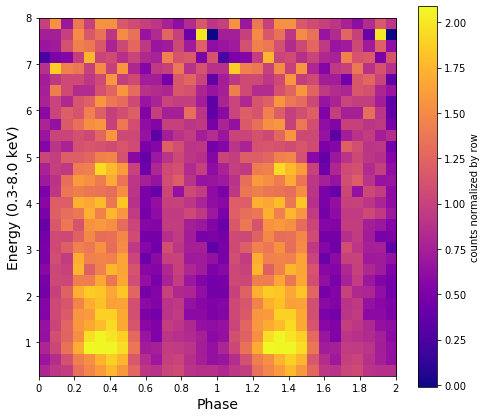

In [100]:
#bg-subtracted
plt.figure(figsize=(8,7))
plt.imshow(norm_bg,cmap='plasma')
plt.colorbar(label='counts normalized by row')
plt.yticks([28.5,28.5-32/7.7,28.5-2*32/7.7,28.5-3*32/7.7,28.5-4*32/7.7,28.5-5*32/7.7,28.5-6*32/7.7,28.5-7*32/7.7],[1,2,3,4,5,6,7,8])
plt.xticks([-0.5,2.7,6.4-.5,9.6-.5,12.8-.5,16-.5,19.2-.5,22.4-.5,25.6-.5,28.8-.5,31.5],[0,.2,.4,.6,.8,1,1.2,1.4,1.6,1.8,2])
plt.xlabel('Phase',fontsize=14)
plt.ylabel('Energy (0.3-8.0 keV)',fontsize=14)

Text(0, 0.5, 'Energy (0.3-8.0 keV)')

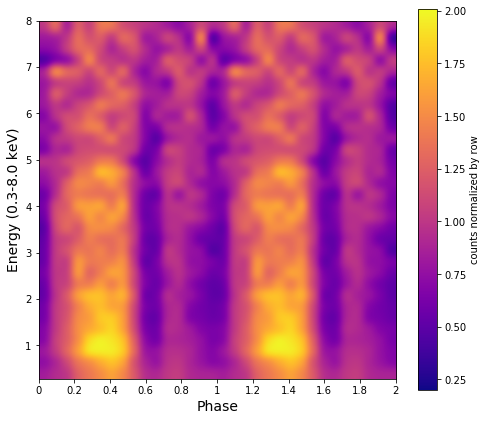

In [101]:
plt.figure(figsize=(8,7))
plt.imshow(norm,cmap='plasma',interpolation='gaussian')
plt.colorbar(label='counts normalized by row')
plt.yticks([28.5,28.5-32/7.7,28.5-2*32/7.7,28.5-3*32/7.7,28.5-4*32/7.7,28.5-5*32/7.7,28.5-6*32/7.7,28.5-7*32/7.7],[1,2,3,4,5,6,7,8])
plt.xticks([-0.5,2.7,6.4-.5,9.6-.5,12.8-.5,16-.5,19.2-.5,22.4-.5,25.6-.5,28.8-.5,31.5],[0,.2,.4,.6,.8,1,1.2,1.4,1.6,1.8,2])
plt.xlabel('Phase',fontsize=14)
plt.ylabel('Energy (0.3-8.0 keV)',fontsize=14)
#sf('gsmoothenhist')

Text(0, 0.5, 'Energy (0.3-8.0 keV)')

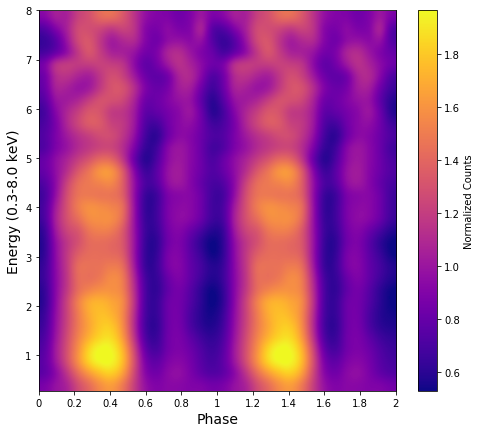

In [102]:
#smoothed with background-subtraction
#better way of smoothing
plt.figure(figsize=(8,7))
norm_2_bg_fil=gaussian_filter(norm_bg, 0.8,mode='wrap')
im = plt.imshow(norm_2_bg_fil,cmap='plasma',interpolation='spline16',aspect='auto')
#plt.imshow(norm_bg,cmap='plasma',interpolation='gaussian')
plt.colorbar(label='Normalized Counts')
plt.yticks([28.5,28.5-32/7.7,28.5-2*32/7.7,28.5-3*32/7.7,28.5-4*32/7.7,28.5-5*32/7.7,28.5-6*32/7.7,28.5-7*32/7.7],[1,2,3,4,5,6,7,8])
plt.xticks([-0.5,2.7,6.4-.5,9.6-.5,12.8-.5,16-.5,19.2-.5,22.4-.5,25.6-.5,28.8-.5,31.5],[0,.2,.4,.6,.8,1,1.2,1.4,1.6,1.8,2])
plt.xlabel('Phase',fontsize=14)
plt.ylabel('Energy (0.3-8.0 keV)',fontsize=14)
#sf('bggsmoothenph')

In [103]:
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

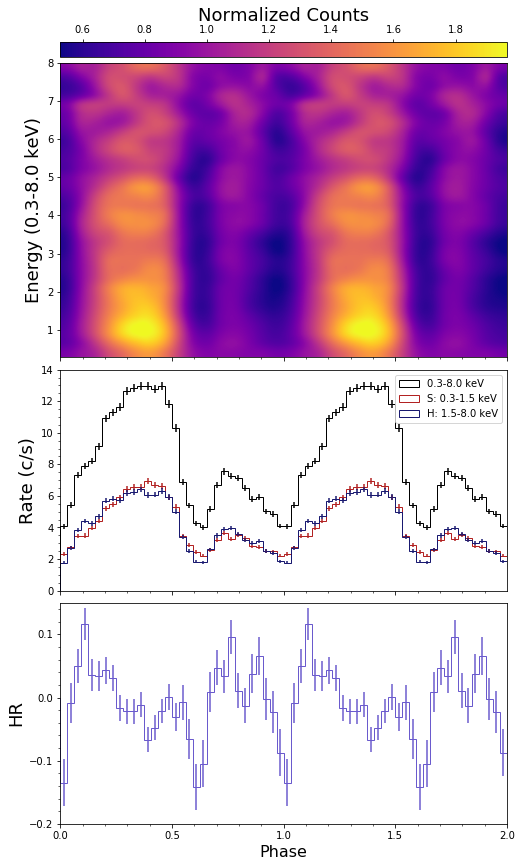

In [104]:
#heat map as middle panel with pulse profile and hardness ratios
reload(p)
#background-subtracted, 32 phase bins (16 in "final" notebook)
rateh,rateherr = p.phaserate(hists3,mids3,exptime,ens=['0.3-8.0 keV','S: 0.3-1.5 keV','H: 1.5-8.0 keV'],colors=['black','firebrick','midnightblue'],rate=True,figsize=(8,14),bgb=True,bg=bg,enhist=True,ed=ed,pd=pd,norm_bg=norm_bg,yrange2=[-0.2,0.15])

#sf('threepulse2')


### adding normalization by column instead of by row


In [105]:
normc = np.zeros((32,32))
for i in range(32):
    normc[:,i] = enhist[0][i,:]/np.median(enhist[0][i,:])

Text(0, 0.5, 'Energy')

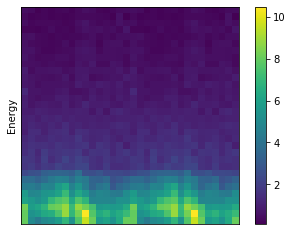

In [106]:
plt.imshow(normc,origin='lower') #does this make sense as the column normalization? but then why not just 1d hist
plt.yticks([])
plt.xticks([])
plt.colorbar()
plt.ylabel('Energy')

In [107]:
enhist[0][:,0] #row

array([272., 305., 317., 412., 451., 485., 530., 482., 398., 303., 293.,
       331., 342., 295., 288., 290., 272., 305., 317., 412., 451., 485.,
       530., 482., 398., 303., 293., 331., 342., 295., 288., 290.])

In [108]:
norm.shape

(32, 32)

In [109]:
enhist[0][2] #column

array([317., 417., 451., 384., 359., 302., 249., 198., 112.,  99.,  92.,
       107.,  88., 101.,  82.,  68.,  78.,  60.,  39.,  50.,  35.,  39.,
        43.,  35.,  24.,  27.,  26.,  26.,  14.,  24.,  15.,  12.])

In [110]:
enhist[1] #binning along x

array([7.94734130e-07, 6.24999666e-02, 1.24999138e-01, 1.87498310e-01,
       2.49997482e-01, 3.12496654e-01, 3.74995826e-01, 4.37494998e-01,
       4.99994169e-01, 5.62493341e-01, 6.24992513e-01, 6.87491685e-01,
       7.49990857e-01, 8.12490029e-01, 8.74989201e-01, 9.37488372e-01,
       9.99987544e-01, 1.06248672e+00, 1.12498589e+00, 1.18748506e+00,
       1.24998423e+00, 1.31248340e+00, 1.37498258e+00, 1.43748175e+00,
       1.49998092e+00, 1.56248009e+00, 1.62497926e+00, 1.68747843e+00,
       1.74997761e+00, 1.81247678e+00, 1.87497595e+00, 1.93747512e+00,
       1.99997429e+00])

In [111]:
enhist[2] #binning along y

array([0.3     , 0.540625, 0.78125 , 1.021875, 1.2625  , 1.503125,
       1.74375 , 1.984375, 2.225   , 2.465625, 2.70625 , 2.946875,
       3.1875  , 3.428125, 3.66875 , 3.909375, 4.15    , 4.390625,
       4.63125 , 4.871875, 5.1125  , 5.353125, 5.59375 , 5.834375,
       6.075   , 6.315625, 6.55625 , 6.796875, 7.0375  , 7.278125,
       7.51875 , 7.759375, 8.      ])

## hard and soft 2D hists

Text(0.5, 0, 'Phase')

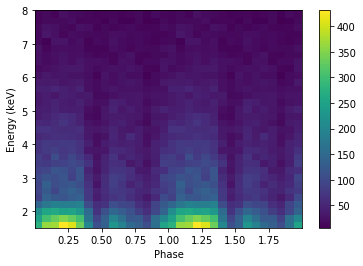

In [112]:
hph = hard_evt['TIME']%pd
hph1 = hph/pd
hph2 = hph1 + 1
hph3 = list(hph1)+list(hph2)
hed2 = list(hard_evt['PI'])+list(hard_evt['PI'])
enhisth = plt.hist2d(hph3,np.array(hed2)/100,bins=32)
plt.colorbar()
plt.ylabel('Energy (keV)')
plt.xlabel('Phase')

Text(0.5, 0, 'Phase')

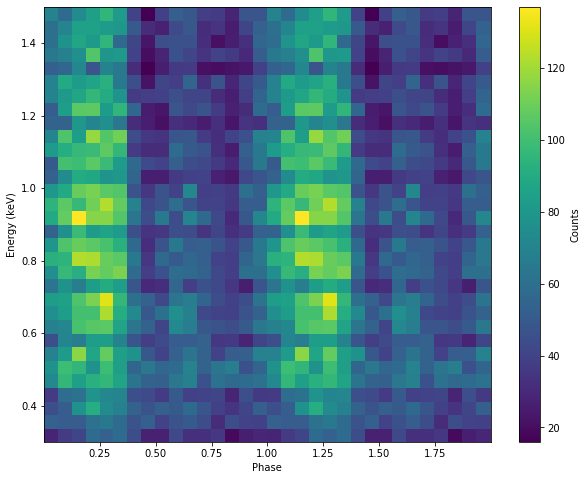

In [113]:
plt.figure(figsize=(10,8))
sph = soft_evt['TIME']%pd
sph1 = sph/pd
sph2 = sph1 + 1
sph3 = list(sph1)+list(sph2)
sed2 = list(soft_evt['PI'])+list(soft_evt['PI'])
enhists = plt.hist2d(sph3,np.array(sed2)/100,bins=32)
plt.colorbar(label='Counts')
plt.ylabel('Energy (keV)')
plt.xlabel('Phase')
#sf('softenphase')

> stop for now, but there's probably a better way to use enhist to make 2d hist

# Paper Comparison With Extracted Errors
> and then find out luminosity then and now

In [114]:
pde = pandas.read_csv(path+'2000werrors.csv',names=['Phase','Int']) #normalized intensity

In [115]:
len(pde[40:])

80

In [116]:
p_err = []
for j in np.arange(0,40):
    p_err.append(pde['Int'][40+2*j])

In [117]:
p_err = np.array(p_err)

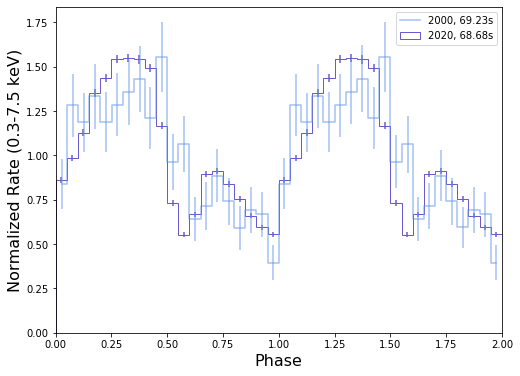

In [118]:
reload(p)
mod = p.phaseroll(p3[1],p3[0]/7,2,np.array(pmids3),p3err/7,label='2020, 68.68s')
#plt.savefig(path+'shiftedpp.png',dpi=200,bbox_inches='tight')
paproll = np.roll(papdata['Int'],-1)
perroll = np.roll(p_err,-1)
#paproll=papdata['Int']
#perroll=p_err

plt.step(papdata['Phase']+.025,paproll,where='mid',color='cornflowerblue',alpha=.6,label='2000, 69.23s')
plt.errorbar(papdata['Phase']+.025,paproll,yerr=np.abs(perroll-paproll),alpha=.6,linestyle='none',color='cornflowerblue')
plt.legend()
#plt.ylabel('Counts/s (0.3-7.5 keV)')
plt.ylabel('Normalized Rate (0.3-7.5 keV)',fontsize=16)
sf('pres0020cr')

Text(0, 0.5, 'Normalized Rate (0.3-7.5 keV)')

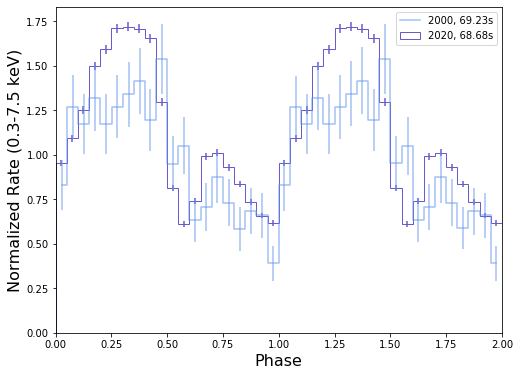

In [119]:
#changing to normalizing each count rate individually
reload(p)
mod = p.phaseroll(p3[1],p3[0]/np.median(p3[0]),2,np.array(pmids3),p3err/np.median(p3[0]),label='2020, 68.68s')
#plt.savefig(path+'shiftedpp.png',dpi=200,bbox_inches='tight')
paproll = np.roll(papdata['Int'],-1)
perroll = np.roll(p_err,-1)
#paproll=papdata['Int']
#perroll=p_err

plt.step(papdata['Phase']+.025,paproll/np.median(paproll),where='mid',color='cornflowerblue',alpha=.6,label='2000, 69.23s')
plt.errorbar(papdata['Phase']+.025,paproll/np.median(paproll),yerr=np.abs(perroll-paproll),alpha=.6,linestyle='none',color='cornflowerblue')
plt.legend()
#plt.ylabel('Counts/s (0.3-7.5 keV)')
plt.ylabel('Normalized Rate (0.3-7.5 keV)',fontsize=16)
#sf('pres0020cr')

In [120]:
pwd

'/Users/lenatreiber/Desktop/Yale'

In [655]:
import hendrics.io
import hendrics.plot as hp

In [656]:
ez=hendrics.io.load_folding('LXP_69_NICER/rxj0529_gti_bary_0.3_10.0_nicer_xti_Z2n_0.01-0.02Hz.p')

INFO: Loading data and info from LXP_69_NICER/rxj0529_gti_bary_0.3_10.0_nicer_xti_Z2n_0.01-0.02Hz.p [hendrics.io]


Text(0, 0.5, 'Z2n stat')

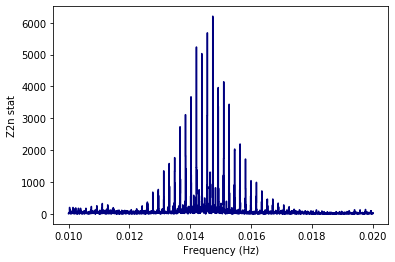

In [657]:
#did the shape change?
plt.plot(ez.freq, ez.stat, drawstyle='steps-mid',color='navy')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Z2n stat')
#sf('Zsearch') #this looks different from the one in Overleaf...

In [658]:
p_res = pandas.DataFrame(columns=['freq','stat']) #periodogram result
p_res['freq'] = ez.freq
p_res['stat'] = ez.stat 
p_res = p_res.sort_values(by='stat',ascending=False)

In [659]:
p_res[:5]

,freq,stat
1226,0.014739,6201.415044
1180,0.014561,5680.922022
1087,0.014202,5234.783437
1133,0.014379,5029.650336
1319,0.015098,4146.449539


In [126]:
1/.01456

68.68131868131869

In [127]:
1/.014739

67.8472080873872

In [128]:
1/.014381

69.53619358876296

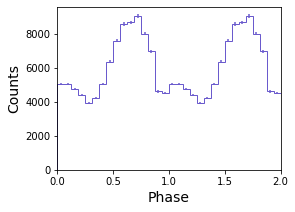

In [129]:
#test nearest peaks using e-fold
testpeaks = p.phasehist(eds,69.53619358876296,bins=32,figsize=(4,3)) 

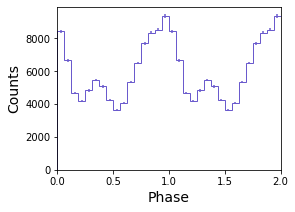

In [130]:
testpeaks = p.phasehist(eds,67.8472080873872,bins=32,figsize=(4,3)) 

In [131]:
#newer model
mo = hendrics.io.load_model('LXP_69_NICER/rxj0529_gti_bary_0.3_10.0_nicer_xti_Z2n_0.01-0.02Hz__mod0__.p') 
print(mo) 
print(mo[0].mean) 
print(mo[0].stddev)

(<Gaussian1D(amplitude=6225.80147551, mean=0.01473913, stddev=0.00000235)>, 'Astropy', None)
Parameter('mean', value=0.014739125491457433)
Parameter('stddev', value=2.3508814965717104e-06, bounds=(1.1754943508222875e-38, None))


In [132]:
1/0.014739125491457433

67.8466304245516

In [133]:
mo

(<Gaussian1D(amplitude=6225.80147551, mean=0.01473913, stddev=0.00000235)>,
 'Astropy',
 None)

# Read in Joint Event File and Look at Pulse Profile
- then update paper comparison

In [134]:
com1 = p.readevt(path+'ni3585010107_fil_bar.evt')
com2 = p.readevt(path+'ni3585010106_fil_bar_EN.evt')

In [135]:
#filter energies
com1 = com1[com1['PI']<=800]
com1 = com1[com1['PI']>=30]
com2 = com2[com2['PI']<=800]
com2 = com2[com2['PI']>=30]

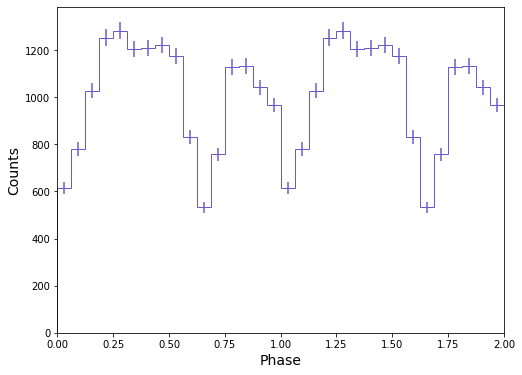

In [136]:
#plot profile with new period
comp1 = p.phasehist(com1,1/0.014580845483718545) #about 68.56

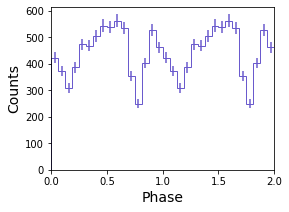

In [137]:
comp2 = p.phasehist(com2,1/0.014580845483718545,figsize=(4,3)) #about 68.56

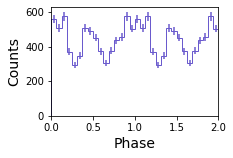

In [138]:
comp2 = p.phasehist(com2,1/0.01440609560258709,figsize=(3,2)) #best for com2: 69.4

In [139]:
from astropy.table import join

In [140]:
com1.remove_columns('EVENT_FLAGS')

In [141]:
com2.remove_columns('EVENT_FLAGS')

In [142]:
com = join(com1,com2,join_type='outer')

In [143]:
len(com) - (len(com1)+len(com2))

0

Text(0, 0.5, 'Counts (0.3-8.0 keV)')

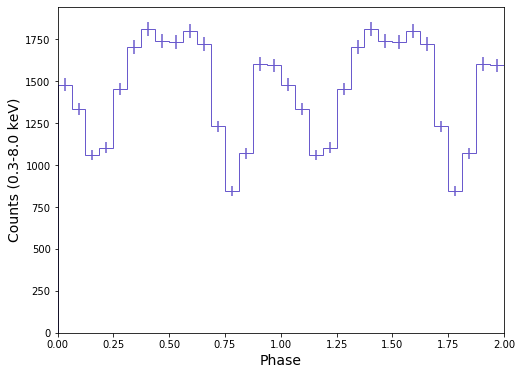

In [144]:
comp = p.phasehist(com,1/0.01458397154022299) #about 68.56
plt.ylabel('Counts (0.3-8.0 keV)',fontsize=14)
#sf('newpp')

In [145]:
compd = 1/0.01458397154022299

In [146]:
comsoft = com[com['PI']<=150]
comhard = com[com['PI']>150]

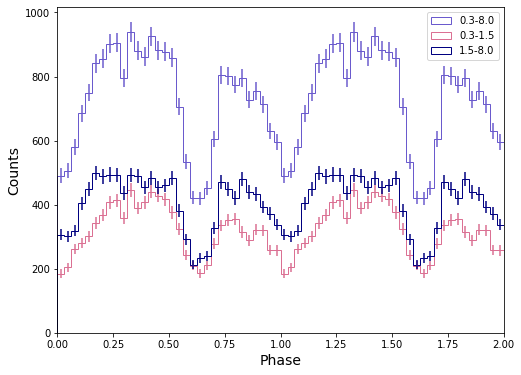

In [147]:
#returns hists and mids
#epoch difference of 7
comhd,comhdm = p.phasehist_sh([com,comsoft,comhard],compd,ens=['0.3-8.0','0.3-1.5','1.5-8.0'],bins=64,epoch=58)
#sf('comhs')

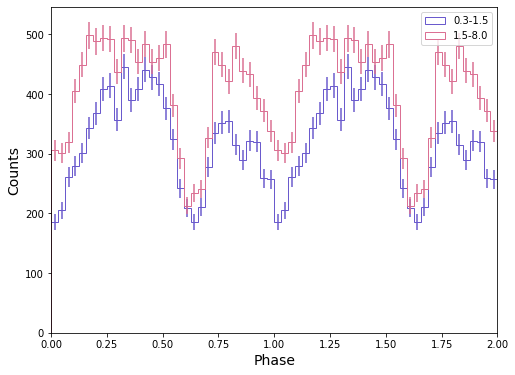

In [148]:
comsh,comshm = p.phasehist_sh([comsoft,comhard],compd,ens=['0.3-1.5','1.5-8.0'],bins=64,epoch=58)


## find average count rate 
- will add bg later
- first, need exposure time

In [149]:
# find time from each
comtim1 = p.readevt(path+'ni3585010107_fil_bar.evt',ind=2)
comtim2 = p.readevt(path+'ni3585010106_fil_bar_EN.evt',ind=2)
comtim1[:5]

START,STOP
float64,float64
204442167.41851154,204442168.41850874
204442172.41849747,204442173.4184946
204442177.41848305,204442179.41847718
204442187.41845316,204442189.41844702
204442193.41843456,204442200.41841224


In [150]:
comt1 = np.sum(comtim1['STOP']-comtim1['START'])
comt2 = np.sum(comtim2['STOP']-comtim2['START'])

In [641]:

comtim1[0]['START']-comtim2[-1]['STOP']

27269.149053245783

In [151]:
comt = comt1 + comt2
comt #total exposure time; only a problem if there's any overlap

4658.969603538513

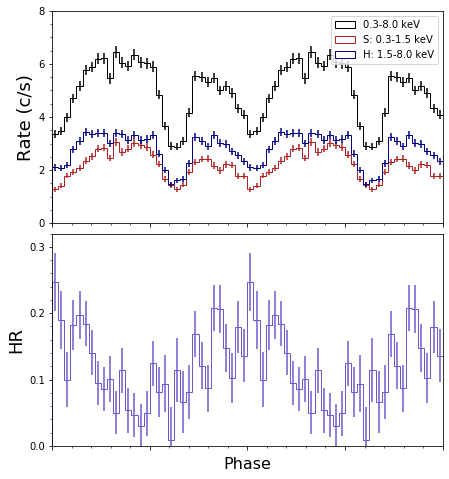

In [613]:
#ask if exposure time correct
#no bg subtraction
reload(p)
comh = p.phaserate(comhd,comhdm,comt,ens=['0.3-8.0 keV','S: 0.3-1.5 keV','H: 1.5-8.0 keV'],colors=['black','firebrick','navy'],rate=True,figsize=(7,8),yrange1=[0,7],yrange2=[0,0.32])
#sf('newhr')
#not sure why there are no tick labels on x-axis

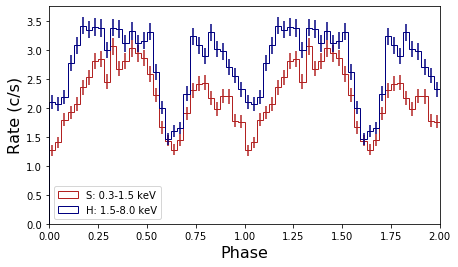

In [153]:
reload(p)
comh = p.phaserate(comsh,comshm,comt,ens=['S: 0.3-1.5 keV','H: 1.5-8.0 keV'],colors=['firebrick','navy'],figsize=(7,4),yrange1=[0,8.5])
#sf('presnewpp')

In [643]:
#guessing that bg percentages are the same
combg = [.086*len(comsoft)/comt, .081*len(comhard)/comt, .083*len(com)/comt]

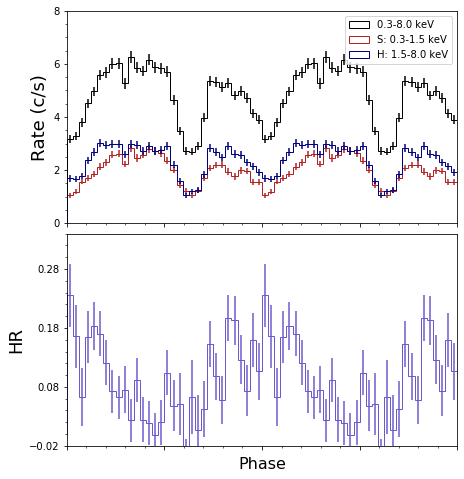

In [645]:
reload(p)
comhr,comhbg,comhbgerr = p.phaserate(comhd,comhdm,comt,ens=['0.3-8.0 keV','S: 0.3-1.5 keV','H: 1.5-8.0 keV'],colors=['black','firebrick','navy'],rate=True,figsize=(7,8),
                  bgb=True,bg=combg,yrange1=[0,7],yrange2=[-.02,0.34],rethr=True)
#sf('newhrbg')


Text(0, 0.5, 'Hardness Ratio')

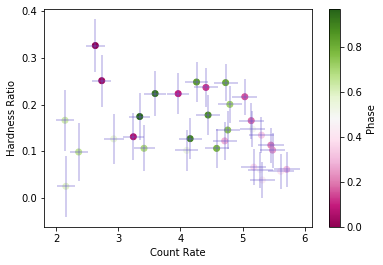

In [155]:
#rateh gives binning and values for three energy bands
#want to compare rate to HR, without phase
chr_c = pandas.DataFrame(columns=['count rate','HR','count rate err', 'HR err','phase'])
chr_c['count rate'] = comhbg[0][0][:32]
chr_c['count rate err'] = comhbgerr[0][:32]
chr_c['HR'] = comhr[0][:32]
chr_c['HR err'] = comhr[1][:32]
chr_c['phase'] = comhbg[0][1][:32]
plt.errorbar(chr_c['count rate'],chr_c['HR'],xerr=chr_c['count rate err'],yerr=chr_c['HR err'],linestyle='none',color='slateblue',alpha=.4)
plt.scatter(chr_c['count rate'],chr_c['HR'],c=chr_c['phase'],cmap='PiYG')
plt.colorbar(label='Phase')
plt.xlabel('Count Rate')
plt.ylabel('Hardness Ratio')
#sf('chrcr_phase')

In [156]:
#find average count rate -- and then check on original avg ct rate
len(com)/comt

4.995310547277241

In [157]:
#old rates
print('avg soft count rate: ',len(soft_evt)/exptime)
print('avg hard count rate: ',len(hard_evt)/exptime) 
print('avg count rate: ',len(ed)/exptime) 
print((len(soft_evt)/exptime)+(len(hard_evt)/exptime))

avg soft count rate:  4.484965190342171
avg hard count rate:  4.432676640497704
avg count rate:  8.917641830839875
8.917641830839875


In [158]:
#new rates
print('avg new soft count rate: ',len(comsoft)/comt)
print('avg new hard count rate: ',len(comhard)/comt) 
print('avg new count rate: ',len(com)/comt) 
print((len(comsoft)/comt)+(len(comhard)/comt))

avg new soft count rate:  2.2067111131593395
avg new hard count rate:  2.7885994341179012
avg new count rate:  4.995310547277241
4.99531054727724


In [159]:
#find estimated bg-subtracted count rate
totrate = comhbg[0][0] #just went up to 32 phase bins (64 total) to match

In [160]:
len(totrate)

64

In [161]:
np.mean(totrate)

4.255146275317532

# Add Other Analysis
> - first: energy phase histogram
    - then try pulsed fraction

In [647]:
comph = com['TIME']%compd

Text(0.5, 0, 'Phase')

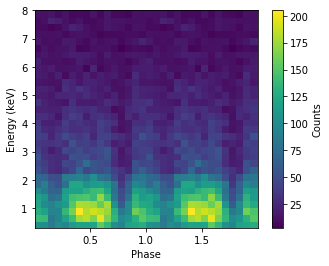

In [648]:
#epoch 3 com energy hist
plt.figure(figsize=(5,4)) 
ph1 = comph/compd
ph2 = ph1 + 1
ph3 = list(ph1)+list(ph2)
ed2 = list(com['PI'])+list(com['PI'])
comenhist = plt.hist2d(ph3,np.array(ed2)/100,bins=32) #convert from PI to keV
plt.colorbar(label='Counts')
plt.ylabel('Energy (keV)')
plt.xlabel('Phase')
#sf('enphase2d')

In [649]:
#no bg-subtraction for now
comnorm = np.zeros((32,32))
for i in range(32):
    comnorm[i,:] = comenhist[0][:,31-i]/np.median(comenhist[0][:,31-i]) 

Text(0, 0.5, 'Energy (0.3-8.0 keV)')

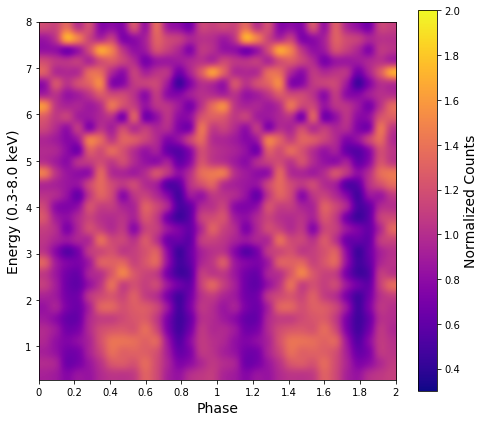

In [650]:
#not bg-subtracted
plt.figure(figsize=(8,7))
comnorm_fil=gaussian_filter(comnorm, 0.8,mode='wrap')
im = plt.imshow(comnorm_fil,cmap='plasma',interpolation='spline16',aspect='auto')
plt.imshow(comnorm,cmap='plasma',interpolation='gaussian')
cbar = plt.colorbar(label='Normalized Counts')
cbar.set_label(label='Normalized Counts',size=14)
plt.yticks([28.5,28.5-32/7.7,28.5-2*32/7.7,28.5-3*32/7.7,28.5-4*32/7.7,28.5-5*32/7.7,28.5-6*32/7.7,28.5-7*32/7.7],[1,2,3,4,5,6,7,8])
plt.xticks([-0.5,2.7,6.4-.5,9.6-.5,12.8-.5,16-.5,19.2-.5,22.4-.5,25.6-.5,28.8-.5,31.5],[0,.2,.4,.6,.8,1,1.2,1.4,1.6,1.8,2])
plt.xlabel('Phase',fontsize=14)
plt.ylabel('Energy (0.3-8.0 keV)',fontsize=14)

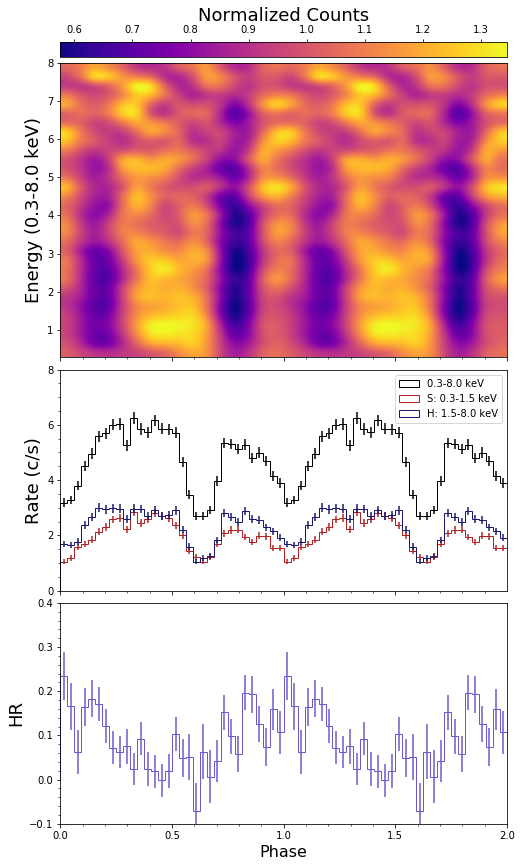

In [652]:
#make three panel figure
crateh,crateherr = p.phaserate(comhd,comhdm,comt,ens=['0.3-8.0 keV','S: 0.3-1.5 keV','H: 1.5-8.0 keV'],colors=['black','firebrick','midnightblue'],
                               rate=True,figsize=(8,14),bgb=True,bg=combg,enhist=True,ed=com,pd=compd,norm_bg=comnorm,yrange1=[0,7],yrange2=[-0.1,0.4])
sf('newthreepulse')


In [167]:
compd

68.56842782790496

Text(0, 0.5, 'Counts')

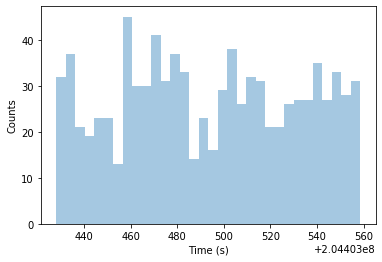

In [168]:
#pulsations by-eye, without any folding
sb.distplot(com['TIME'][1550:2450],kde=False,bins=32)
plt.xlabel('Time (s)')
plt.ylabel('Counts')

In [169]:
def pf2(countrate,err):
    totlen = len(countrate)
    r=countrate[:int(totlen/2)]
    err=err[:int(totlen/2)]
    rerr=unumpy.uarray(r,err)
    rmax = rerr.max()
    rmin = rerr.min()
    pf = (rmax-rmin)/(rmax+rmin)#count rate in phase bins up to 1
    return pf

In [170]:
#total bg-subtracted pulsed fraction
pf2(comhbg[0][0],comhbgerr[0])

0.45387969190105737+/-0.02988576237767333

In [171]:
#soft pulsed fraction
pf2(comhbg[1][0],comhbgerr[1])

0.5031929871541577+/-0.04430512781024119

In [172]:
#hard pulsed fraction
pf2(comhbg[2][0],comhbgerr[2])

0.4699474851366212+/-0.04039578845885604

In [173]:
#make tables for energies
#overwrote ealire ones with this!
en1 = com[com['PI']<=70]
en2 = com[com['PI']>70]
en2 = en2[en2['PI']<=100]
en3 = com[com['PI']>100]
en3 = en3[en3['PI']<=150]
en4 = com[com['PI']>150]
en4 = en4[en4['PI']<=200]
en5 = com[com['PI']>200]
en5 = en5[en5['PI']<=300]
en6 = com[com['PI']>300]
en6 = en6[en6['PI']<=500]
en7 = com[com['PI']>500]
en7 = en7[en7['PI']<=800]

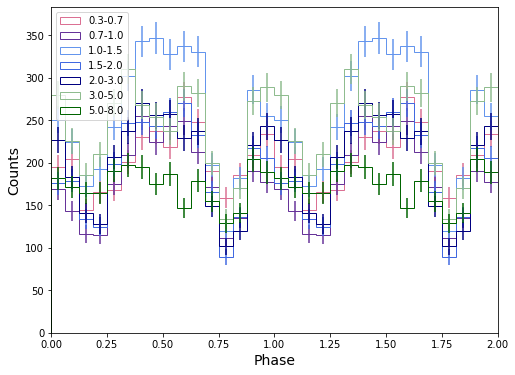

In [174]:

#up to 8.0 for now since higher energies filtered out
cpfens,cpfmids = p.phasehist_sh([en1,en2,en3,en4,en5,en6,en7],compd,ens=['0.3-0.7','0.7-1.0','1.0-1.5','1.5-2.0','2.0-3.0','3.0-5.0','5.0-8.0'],
               colors=['palevioletred','rebeccapurple','cornflowerblue','royalblue','navy','darkseagreen','darkgreen'])

In [175]:
#without bg-subtraction
cpf = []
cpfn = []
cpfe = []
for i in range(7):
    cr = cpfens[i][0]
    totlen = len(cr)
    r = cr[:int(totlen/2)]
    rerr = unumpy.uarray(r,np.sqrt(r))
    rmax = rerr.max()
    rmin = rerr.min()
    cpf.append((rmax-rmin)/(rmax+rmin))
    cpfn.append(((rmax-rmin)/(rmax+rmin)).n)
    cpfe.append(((rmax-rmin)/(rmax+rmin)).s)
cpfn

[0.3144208037825059,
 0.39344262295081966,
 0.4860813704496788,
 0.5041782729805014,
 0.45161290322580644,
 0.3963963963963964,
 0.22522522522522523]

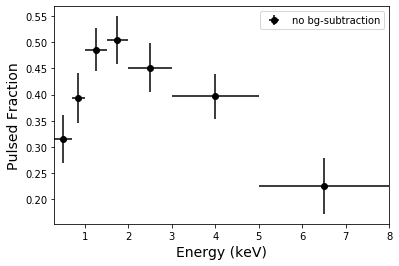

In [653]:
#not bg-sub
plt.errorbar([.5,.85,1.25,1.75,2.5,4,6.5],cpfn,yerr=cpfe,xerr=[.2,.15,.25,.25,.5,1,1.5],marker='o',color='black',linestyle='none',label='no bg-subtraction')
plt.xlim(.3,8)


plt.xlabel('Energy (keV)',fontsize=14)
plt.ylabel('Pulsed Fraction',fontsize=14)
plt.legend()
sf('comPF')

# compare both pulse profiles to paper

In [177]:
#limit to 7.5 keV
compap = com[com['PI']<=750]

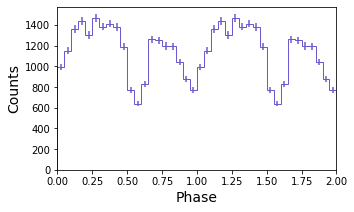

In [178]:
reload(p)
compaph,commids = p.phasehist(compap,compd,bins=40,epoch=-15,figsize=(5,3))

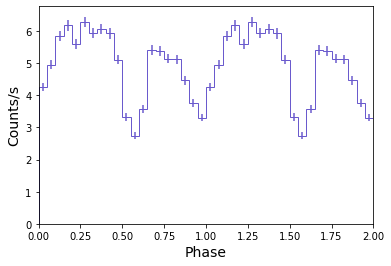

In [179]:
compr,cerr = p.s_phaserate(compaph,commids,comt,bins=20)

In [180]:
np.sqrt(compaph[0])*1/np.mean(compaph[0])

array([0.02749905, 0.02964671, 0.03218633, 0.03310863, 0.03150411,
       0.03339519, 0.03249276, 0.03283118, 0.03243406, 0.03013129,
       0.02425886, 0.02208776, 0.02513848, 0.03100411, 0.03089327,
       0.03020709, 0.03014393, 0.02817002, 0.02584127, 0.02422742,
       0.02749905, 0.02964671, 0.03218633, 0.03310863, 0.03150411,
       0.03339519, 0.03249276, 0.03283118, 0.03243406, 0.03013129,
       0.02425886, 0.02208776, 0.02513848, 0.03100411, 0.03089327,
       0.03020709, 0.03014393, 0.02817002, 0.02584127, 0.02422742])

In [181]:
np.sqrt(compaph[0])*(1/np.mean(compaph[0]))

array([0.02749905, 0.02964671, 0.03218633, 0.03310863, 0.03150411,
       0.03339519, 0.03249276, 0.03283118, 0.03243406, 0.03013129,
       0.02425886, 0.02208776, 0.02513848, 0.03100411, 0.03089327,
       0.03020709, 0.03014393, 0.02817002, 0.02584127, 0.02422742,
       0.02749905, 0.02964671, 0.03218633, 0.03310863, 0.03150411,
       0.03339519, 0.03249276, 0.03283118, 0.03243406, 0.03013129,
       0.02425886, 0.02208776, 0.02513848, 0.03100411, 0.03089327,
       0.03020709, 0.03014393, 0.02817002, 0.02584127, 0.02422742])

Text(0, 0.5, 'Normalized Count Rate (0.3-7.5 keV)')

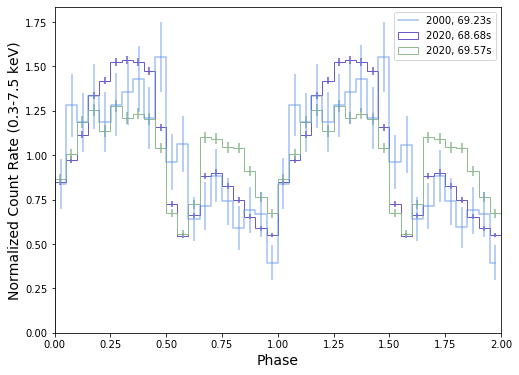

In [182]:
#filter energy to less than 7.5
#decide how to scale this fig
reload(p)
mod = p.phaseroll(p3[1],p3[0]/np.mean(p3[0]),2,pmids3,p3err/np.mean(p3[0]),label='2020, 68.68s')
#scaling up
comprs,cerrs = p.s_phaserate(compaph,commids,comt,bins=20,color='darkseagreen',label='2020, 69.57s',scale=1./np.mean(compaph[0]))
#comsc = plt.step(compaph,commids,where='mid')
#plt.savefig(path+'shiftedpp.png',dpi=200,bbox_inches='tight')
paproll = np.roll(papdata['Int'],-1)
#paproll=papdata['Int']
#lining up bins
plt.step(papdata['Phase']+.025,paproll/np.mean(paproll),where='mid',color='cornflowerblue',alpha=.6,label='2000, 69.23s')
plt.errorbar(papdata['Phase']+.025,paproll/np.mean(paproll),yerr=np.mean(paproll)*np.abs(perroll-paproll),alpha=.6,linestyle='none',color='cornflowerblue')
plt.legend()
plt.ylabel('Normalized Count Rate (0.3-7.5 keV)')
#sf('pap2')

In [183]:
np.median(paproll/np.median(paproll))

1.0

In [184]:
np.median(compaph[0]/np.median(compaph[0]))

1.0

In [185]:
np

<module 'numpy' from '/opt/anaconda3/lib/python3.7/site-packages/numpy/__init__.py'>

In [189]:
com['TIME'][0]-ed['TIME'][-1] #nine days later

829919.4271355569

In [190]:
829919/(3600*24)

9.605543981481482

In [191]:
ed['TIME'][-1]-ed['TIME'][0]

128794.38912701607

In [192]:
128794/(3600*24)

1.4906712962962962

In [193]:
(com['TIME'][-1]-com['TIME'][0])/(3600*24)

0.8419586025661341

In [194]:
comt

4658.969603538513

## 9/26/20 Update
- NICER in three epochs
- verify times of three epochs and compare to what we had above
- use old timing solutions to fold data/repeat analysis

updating to bary files
updating with background
epoch 1
- 0.3-8.0: 90.5% source (.095*len(ep1)/ep1time)
- 0.3-1.5: 89.1% source (.109*len(soft_ep1)/ep1time)
- 1.5-8.0: 91.8% source (.082*len(hard_ep1)/ep1time)

data epoch1-sun80-spaceweather.pha
back back_epoch1-sun80-spaceweather.pha
resp nicer.rmf
arf nicer.arf
ignore bad
ignore (some energies)
show rate

epoch 3
- 0.3-8.0: 87.7% source 
- 0.3-1.5: 84.4% source 
- 1.5-8.0: 90.2% source 

In [195]:
pwd

'/Users/lenatreiber/Desktop/Yale'

### Load in new evt files

In [549]:
#paths to each epoch
e1path = 'NIC_3ep/epoch1/'
e2path = 'NIC_3ep/epoch2/'
e3path = 'NIC_3ep/epoch3/'
#tables of start and end times from each epoch
tep1 = p.readevt(e1path+'epoch1-sun80-spaceweather_bar.evt',ind=2)
# tep1_nos = p.readevt(e1path+'epoch1-sun80.evt',ind=2)
# ep1_nos = p.readevt(e1path+'epoch1-sun80.evt')

tep2 = p.readevt(e2path+'epoch2-sun80-spaceweather_bar.evt',ind=2)
tep3 = p.readevt(e3path+'epoch3-sun80-spaceweather_bar.evt',ind=2)
#corresponding event tables
ep1 = p.readevt(e1path+'epoch1-sun80-spaceweather_bar.evt')
ep2 = p.readevt(e2path+'epoch2-sun80-spaceweather_bar.evt')
ep3 = p.readevt(e3path+'epoch3-sun80-spaceweather_bar.evt')

In [696]:
hdu_list = fits.open(e1path+'epoch1-sun80-spaceweather_bar.evt', memmap=True)
print(hdu_list[1].header['DATE-OBS'],hdu_list[1].header['DATE-END'])

2020-06-12T14:56:20 2020-06-14T02:41:20


In [699]:
hdu_list = fits.open(e3path+'epoch3-sun80-spaceweather_bar.evt', memmap=True)
print(hdu_list[1].header['DATE-OBS'],hdu_list[1].header['DATE-END'])

2020-06-23T17:14:58 2020-06-24T13:25:44


In [703]:
17.2/24

0.7166666666666667

In [690]:
print(ep1['TIME'][0],ed['TIME'][0])
print(ep1['TIME'][-1],ed['TIME'][-1])

203439313.2262533 203439218.39978236
203568012.80229336 203568012.78890938


In [691]:
print(ep3['TIME'][0],com['TIME'][0])
print(ep3['TIME'][-1],com['TIME'][-1])

204398031.19076422 204397932.21604493
204470677.44025785 204470677.43930665


Text(0, 0.5, 'Counts')

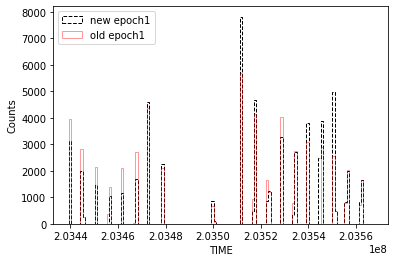

In [550]:
#histogram comparison with bary-corrected
ephist = plt.hist(ep1['TIME'],bins=np.arange(203439218,203568021,1000),label='new epoch1',color='black',histtype='step',linestyle='dashed')
edhist = plt.hist(ed['TIME'],bins=np.arange(203439218,203568021,1000),label='old epoch1',color='red',histtype='step',alpha=.4)
plt.legend(loc='upper left')
plt.xlabel('TIME')
plt.ylabel('Counts')

In [551]:
np.sum(tep1['STOP']-tep1['START'])


6464.003115236759

In [552]:
np.sum(tep3['STOP']-tep3['START'])

3014.9777161478996

In [553]:
np.sum(tep2['STOP']-tep2['START'])/300

1.7599982648094494

In [554]:
ep1 = ep1[ep1['PI']>=30]
ep1 = ep1[ep1['PI']<=800]
soft_ep1 = ep1[ep1['PI']<=150]
hard_ep1 = ep1[ep1['PI']>150]

In [555]:
ep3 = ep3[ep3['PI']>=30]
ep3 = ep3[ep3['PI']<=800]
soft_ep3 = ep3[ep3['PI']<=150]
hard_ep3 = ep3[ep3['PI']>150]

ep2 = ep2[ep2['PI']>=30]
ep2 = ep2[ep2['PI']<=800]
soft_ep2 = ep2[ep2['PI']<=150]
hard_ep2 = ep2[ep2['PI']>150]

### counts pulse profiles 

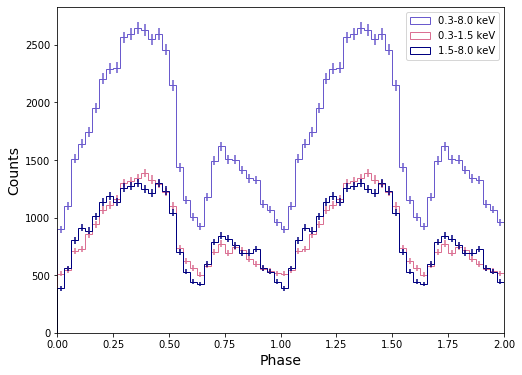

In [557]:
#phase fold with total counts; original period
ep1hists,ep1mids = p.phasehist_sh([ep1,soft_ep1,hard_ep1],pd,ens=['0.3-8.0 keV','0.3-1.5 keV','1.5-8.0 keV'],
                              bins=64,epoch=10)


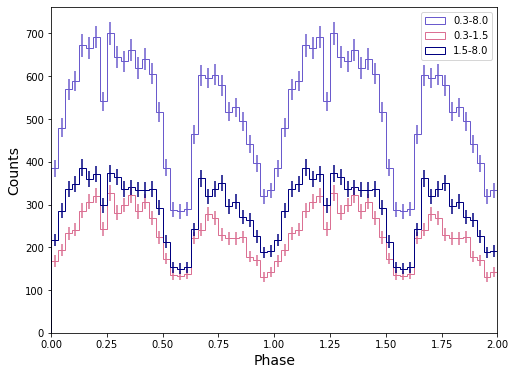

In [558]:
#approximate epoch shift
ep3hists,ep3mids = p.phasehist_sh([ep3,soft_ep3,hard_ep3],compd,ens=['0.3-8.0','0.3-1.5','1.5-8.0'],bins=64,epoch=-15)

Text(0, 0.5, 'Counts')

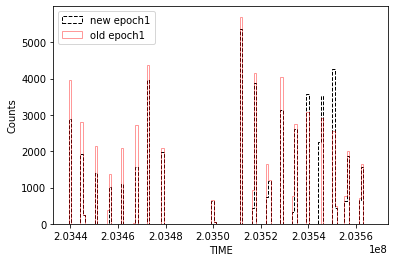

In [559]:
ephist = plt.hist(ep1['TIME'],bins=np.arange(203439218,203568021,1000),label='new epoch1',color='black',histtype='step',linestyle='dashed')
edhist = plt.hist(ed['TIME'],bins=np.arange(203439218,203568021,1000),label='old epoch1',color='red',histtype='step',alpha=.4)
plt.legend(loc='upper left')
plt.xlabel('TIME')
plt.ylabel('Counts')
#sf('ep1hist')


Text(0, 0.5, 'Counts')

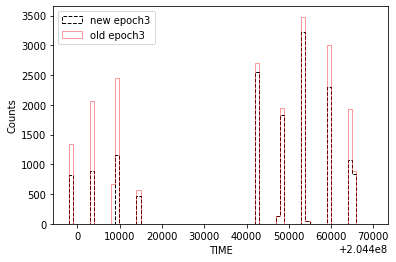

In [560]:
ephist = plt.hist(ep3['TIME'],bins=np.arange(204397932,204470680,1000),label='new epoch3',color='black',histtype='step',linestyle='dashed')
edhist = plt.hist(com['TIME'],bins=np.arange(204397932,204470680,1000),label='old epoch3',color='red',histtype='step',alpha=.4)
plt.legend(loc='upper left')
plt.xlabel('TIME')
plt.ylabel('Counts')
#sf('ep3hist')

In [561]:
compd

68.56842782790496

In [562]:
pd

68.68201618721699

In [563]:
comt

4658.969603538513

# Repeating Usual Analyses on Epochs 1 and 3
- phase-folded data (can re-run w/ bg measurement), PF as function of energy, 2D hists, comparison to 2000 data
- and then can use HENDRICS for epoch 2, see if we should include
- add background subtraction later
- counts phase hists above 

**once finalized, move to separate notebook; clean up code again**

In [564]:
ep1time = np.sum(tep1['STOP']-tep1['START'])
ep2time = np.sum(tep2['STOP']-tep2['START'])
ep3time = np.sum(tep3['STOP']-tep3['START'])

ep1time

6464.003115236759

In [565]:
#background percentages for epoch 1
ep1_ssub = .109*len(soft_ep1)/ep1time #avg rate * percentage that's BG
ep1_hsub = .082*len(hard_ep1)/ep1time
ep1_tsub = .095*len(ep1)/ep1time
print(ep1_ssub,ep1_hsub,ep1_tsub)

0.46250782165511023 0.34814463419663333 0.8064414430296988


In [614]:
len(ep1)/ep1time

8.48885729504946

In [619]:
np.mean(ep1rateh[0][0])

7.682415852019761

### need to clarify if avg count rate for bg-subtraction is overall count rate rather than avg count rate from binning?


In [566]:
# - 0.3-8.0: 87.7% source 
# - 0.3-1.5: 84.4% source 
# - 1.5-8.0: 90.2% source 
ep3_ssub = .156*len(soft_ep3)/ep3time #avg rate * percentage that's BG
ep3_hsub = .098*len(hard_ep3)/ep3time
ep3_tsub = .123*len(ep3)/ep3time
print(ep3_ssub,ep3_hsub,ep3_tsub)

0.38325059379752885 0.30336343618770967 0.6829304206701456


In [567]:
#lists of bg: count rate to subtract from each total, soft, and hard bin, respectively
ep1bg=[ep1_tsub,ep1_ssub,ep1_hsub] #background argument,subtracting once y-axis is counts/s
ep3bg=[ep3_tsub,ep3_ssub,ep3_hsub]

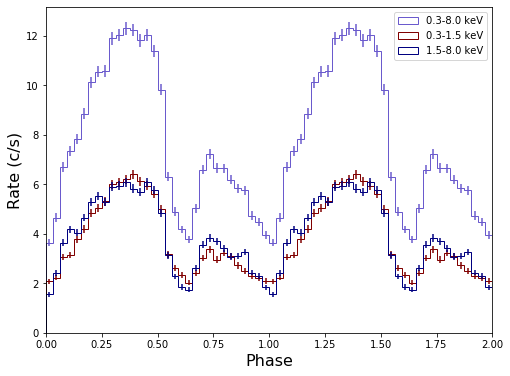

In [568]:
#convert epoch 1 to count rates, bg-subtraction
ep1rateh,ep1errs = p.phaserate(ep1hists,ep1mids,ep1time,ens=['0.3-8.0 keV','0.3-1.5 keV','1.5-8.0 keV'],
                             bgb=True,bg=ep1bg)


In [569]:
ep3time = np.sum(tep3['STOP']-tep3['START'])
ep3time

3014.9777161478996

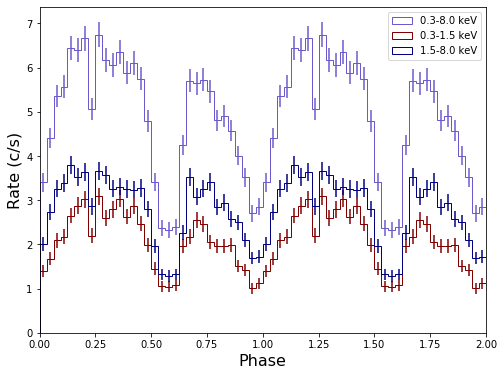

In [570]:
#repeat for epoch 2
ep3rateh,ep3errs = p.phaserate(ep3hists,ep3mids,ep3time,ens=['0.3-8.0 keV','0.3-1.5 keV','1.5-8.0 keV'],
                             bgb=True,bg=ep3bg)

### pulsed fraction as function of energy
- to do: turn into function

In [571]:
#make tables for energies: ep1
ep1_en1 = ep1[ep1['PI']<=70]
ep1_en2 = ep1[ep1['PI']>70]
ep1_en2 = ep1_en2[ep1_en2['PI']<=100]
ep1_en3 = ep1[ep1['PI']>100]
ep1_en3 = ep1_en3[ep1_en3['PI']<=150]
ep1_en4 = ep1[ep1['PI']>150]
ep1_en4 = ep1_en4[ep1_en4['PI']<=200]
ep1_en5 = ep1[ep1['PI']>200]
ep1_en5 = ep1_en5[ep1_en5['PI']<=300]
ep1_en6 = ep1[ep1['PI']>300]
ep1_en6 = ep1_en6[ep1_en6['PI']<=500]
ep1_en7 = ep1[ep1['PI']>500]
ep1_en7 = ep1_en7[ep1_en7['PI']<=800]

data epoch3-sun80-spaceweather.pha
back back_epoch3-sun80-spaceweather.pha
resp nicer.rmf
arf nicer.arf
ignore bad

In [572]:
#how much to subtract from each bin
#'1.0-1.5','1.5-2.0','2.0-3.0','3.0-5.0','5.0-8.0'
ep1_bg1 = .167*len(ep1_en1)/ep1time #avg rate * percentage that's BG
ep1_bg2 = .087*len(ep1_en2)/ep1time
ep1_bg3 = .208*len(ep1_en3)/ep1time
ep1_bg4 = .067*len(ep1_en4)/ep1time
ep1_bg5 = .16*len(ep1_en5)/ep1time
ep1_bg6 = .147*len(ep1_en6)/ep1time
ep1_bg7 = .145*len(ep1_en7)/ep1time

ep1_pfbg = [ep1_bg1,ep1_bg2,ep1_bg3,ep1_bg4,ep1_bg5,ep1_bg6,ep1_bg7]

In [573]:
#make tables for energies: ep3
ep3_en1 = ep3[ep3['PI']<=70]
ep3_en2 = ep3[ep3['PI']>70]
ep3_en2 = ep3_en2[ep3_en2['PI']<=100]
ep3_en3 = ep3[ep3['PI']>100]
ep3_en3 = ep3_en3[ep3_en3['PI']<=150]
ep3_en4 = ep3[ep3['PI']>150]
ep3_en4 = ep3_en4[ep3_en4['PI']<=200]
ep3_en5 = ep3[ep3['PI']>200]
ep3_en5 = ep3_en5[ep3_en5['PI']<=300]
ep3_en6 = ep3[ep3['PI']>300]
ep3_en6 = ep3_en6[ep3_en6['PI']<=500]
ep3_en7 = ep3[ep3['PI']>500]
ep3_en7 = ep3_en7[ep3_en7['PI']<=800]

In [574]:
#epoch 3 bg values
ep3_bg1 = .26*len(ep3_en1)/ep3time #avg rate * percentage that's BG
ep3_bg2 = .125*len(ep3_en2)/ep3time
ep3_bg3 = .314*len(ep3_en3)/ep3time
ep3_bg4 = .087*len(ep3_en4)/ep3time
ep3_bg5 = .228*len(ep3_en5)/ep3time
ep3_bg6 = .201*len(ep3_en6)/ep3time
ep3_bg7 = .195*len(ep3_en7)/ep3time

ep3_pfbg = [ep3_bg1,ep3_bg2,ep3_bg3,ep3_bg4,ep3_bg5,ep3_bg6,ep3_bg7]

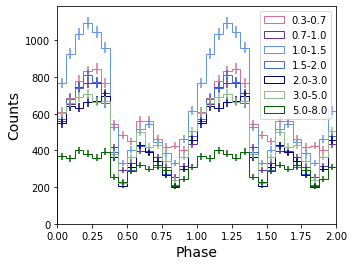

In [575]:
ep1pfens,ep1pfmids = p.phasehist_sh([ep1_en1,ep1_en2,ep1_en3,ep1_en4,ep1_en5,ep1_en6,ep1_en7],pd,ens=['0.3-0.7','0.7-1.0','1.0-1.5','1.5-2.0','2.0-3.0','3.0-5.0','5.0-8.0'],
               colors=['palevioletred','rebeccapurple','cornflowerblue','royalblue','navy','darkseagreen','darkgreen'],figsize=(5,4))

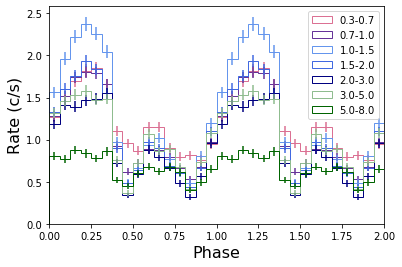

In [576]:
#epoch 1 bg-subtracted count rate hist
reload(p)
ep1pfcr,ep1pfcrerr = p.phaserate(ep1pfens,ep1pfmids,ep1time,ens=['0.3-0.7','0.7-1.0','1.0-1.5','1.5-2.0','2.0-3.0','3.0-5.0','5.0-8.0'],
               colors=['palevioletred','rebeccapurple','cornflowerblue','royalblue','navy','darkseagreen','darkgreen'],
                           rate=False,figsize=(6,4),bgb=True,bg=ep1_pfbg)


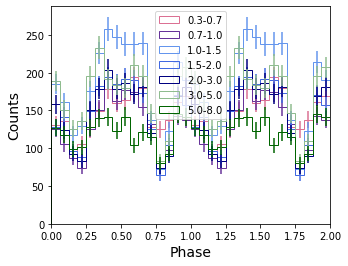

In [577]:
ep3pfens,ep3pfmids = p.phasehist_sh([ep3_en1,ep3_en2,ep3_en3,ep3_en4,ep3_en5,ep3_en6,ep3_en7],compd,ens=['0.3-0.7','0.7-1.0','1.0-1.5','1.5-2.0','2.0-3.0','3.0-5.0','5.0-8.0'],
               colors=['palevioletred','rebeccapurple','cornflowerblue','royalblue','navy','darkseagreen','darkgreen'],figsize=(5,4))


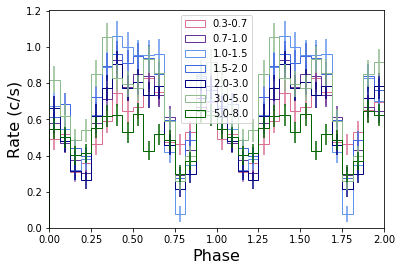

In [578]:
ep3pfcr,ep3pfcrerr = p.phaserate(ep3pfens,ep3pfmids,ep3time,ens=['0.3-0.7','0.7-1.0','1.0-1.5','1.5-2.0','2.0-3.0','3.0-5.0','5.0-8.0'],
               colors=['palevioletred','rebeccapurple','cornflowerblue','royalblue','navy','darkseagreen','darkgreen'],
                           rate=False,figsize=(6,4),bgb=True,bg=ep3_pfbg)

In [579]:
#calculate epoch1 pulsed fractions
ep1pf = []
ep1pfn = []
ep1pfe = []
for i in range(7):
    cr = ep1pfens[i][0]
    totlen = len(cr)
    r = cr[:int(totlen/2)]
    rerr = unumpy.uarray(r,np.sqrt(r))
    rmax = rerr.max()
    rmin = rerr.min()
    ep1pf.append((rmax-rmin)/(rmax+rmin))
    ep1pfn.append(((rmax-rmin)/(rmax+rmin)).n)
    ep1pfe.append(((rmax-rmin)/(rmax+rmin)).s)
ep1pfn

[0.352,
 0.5024390243902439,
 0.5360896986685354,
 0.5901960784313726,
 0.5506117908787542,
 0.524731182795699,
 0.3212520593080725]

In [580]:
#with bg-subtraction
ep1pfr = [] #adding r to variables (for rate)
ep1pfnr = []
ep1pfer = []
for i in range(7):
    cr = ep1pfcr[i][0]
    totlen = len(cr)
    r = cr[:int(totlen/2)] #first half of count rates, since second half just repeated
    e = ep1pfcrerr[i][:int(totlen/2)] #errors originally from sqrt of counts
    rerr = unumpy.uarray(r,e)
    rmax = rerr.max()
    rmin = rerr.min()
    ep1pfr.append((rmax-rmin)/(rmax+rmin))
    ep1pfnr.append(((rmax-rmin)/(rmax+rmin)).n) #value
    ep1pfer.append(((rmax-rmin)/(rmax+rmin)).s) #propogated error
ep1pfnr

[0.4168280592544776,
 0.5472702703528417,
 0.6613322083481736,
 0.6291130420515567,
 0.6541734947401807,
 0.6199559107174563,
 0.37789782224267865]

In [581]:
#calculate epoch3 pulsed fractions
ep3pf = []
ep3pfn = []
ep3pfe = []
for i in range(7):
    cr = ep3pfens[i][0]
    totlen = len(cr)
    r = cr[:int(totlen/2)]
    rerr = unumpy.uarray(r,np.sqrt(r))
    rmax = rerr.max()
    rmin = rerr.min()
    ep3pf.append((rmax-rmin)/(rmax+rmin))
    ep3pfn.append(((rmax-rmin)/(rmax+rmin)).n)
    ep3pfe.append(((rmax-rmin)/(rmax+rmin)).s)
ep3pfn

[0.33793103448275863,
 0.45454545454545453,
 0.5636363636363636,
 0.4980694980694981,
 0.4676258992805755,
 0.47468354430379744,
 0.28888888888888886]

In [582]:
#epoch 3 with bg-subtraction
ep3pfr = [] #adding r to variables (for rate)
ep3pfnr = []
ep3pfer = []
for i in range(7):
    cr = ep3pfcr[i][0]
    totlen = len(cr)
    r = cr[:int(totlen/2)] #first half of count rates, since second half just repeated
    e = ep3pfcrerr[i][:int(totlen/2)] #errors originally from sqrt of counts
    rerr = unumpy.uarray(r,e)
    rmax = rerr.max()
    rmin = rerr.min()
    ep3pfr.append((rmax-rmin)/(rmax+rmin))
    ep3pfnr.append(((rmax-rmin)/(rmax+rmin)).n) #value
    ep3pfer.append(((rmax-rmin)/(rmax+rmin)).s) #propogated error
ep3pfnr

[0.4581205371229565,
 0.5195508050331482,
 0.8686149794054198,
 0.552364059297781,
 0.6154589074657529,
 0.6063457110388778,
 0.36465893870223437]

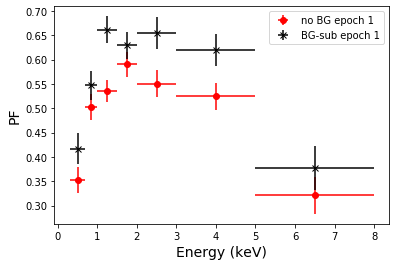

In [606]:
#epoch 1
plt.errorbar([.5,.85,1.25,1.75,2.5,4,6.5],ep1pfn,yerr=ep1pfe,xerr=[.2,.15,.25,.25,.5,1,1.5],marker='o',linestyle='none',color='red',label='no BG epoch 1')
plt.errorbar([.5,.85,1.25,1.75,2.5,4,6.5],ep1pfnr,yerr=ep1pfer,xerr=[.2,.15,.25,.25,.5,1,1.5],marker='x',linestyle='none',color='black',label='BG-sub epoch 1')


plt.legend()
plt.xlabel('Energy (keV)',fontsize=14)
plt.ylabel('PF',fontsize=14)
sf('3Epoch/PFep1')

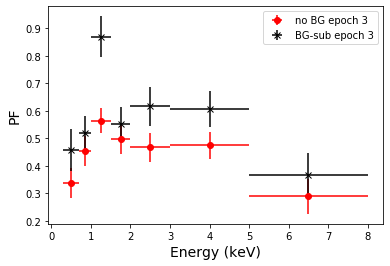

In [607]:
plt.errorbar([.5,.85,1.25,1.75,2.5,4,6.5],ep3pfn,yerr=ep3pfe,xerr=[.2,.15,.25,.25,.5,1,1.5],marker='o',linestyle='none',color='red',label='no BG epoch 3')
plt.errorbar([.5,.85,1.25,1.75,2.5,4,6.5],ep3pfnr,yerr=ep3pfer,xerr=[.2,.15,.25,.25,.5,1,1.5],marker='x',linestyle='none',color='black',label='BG-sub epoch 3')

plt.legend()
plt.xlabel('Energy (keV)',fontsize=14)
plt.ylabel('PF',fontsize=14)
sf('3Epoch/PFep3')

### 2D histograms

Text(0, 0.5, 'Time (s)')

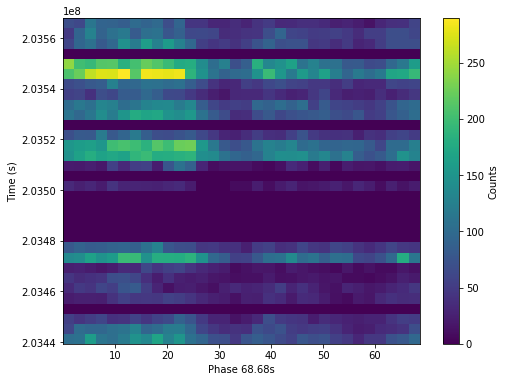

In [585]:
ep1ph = (ep1['TIME'])%pd
plt.figure(figsize=(8,6)) 
hist = plt.hist2d(ep1ph,ep1['TIME'],bins=32)
plt.colorbar(label='Counts')
plt.xlabel('Phase 68.68s')
plt.ylabel('Time (s)')


Text(0, 0.5, 'Time (s)')

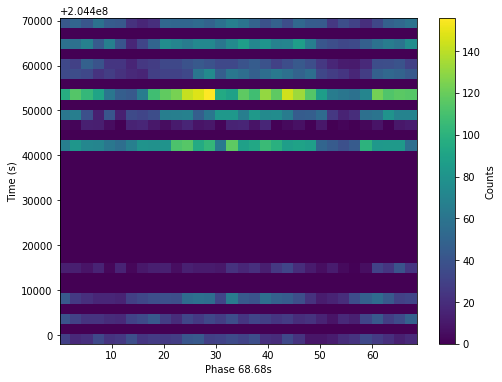

In [586]:
ep3ph = (ep3['TIME'])%compd
plt.figure(figsize=(8,6)) 
hist = plt.hist2d(ep3ph,ep3['TIME'],bins=32)
plt.colorbar(label='Counts')
plt.xlabel('Phase 68.68s')
plt.ylabel('Time (s)')

Text(0.5, 0, 'Phase')

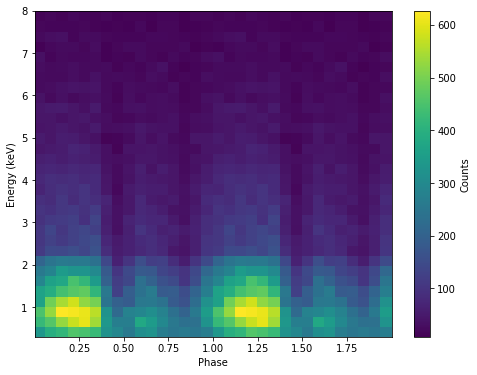

In [587]:
#energy-phase without normalization
#need background as function of energy for these bins
plt.figure(figsize=(8,6)) 
ep1ph1 = ep1ph/pd
ep1ph2 = ep1ph1 + 1
ep1ph3 = list(ep1ph1)+list(ep1ph2)
ep1ed2 = list(ep1['PI'])+list(ep1['PI'])
ep1enhist = plt.hist2d(ep1ph3,np.array(ep1ed2)/100,bins=32) #convert from PI to keV
plt.colorbar(label='Counts')
plt.ylabel('Energy (keV)')
plt.xlabel('Phase')

Text(0.5, 0, 'Phase')

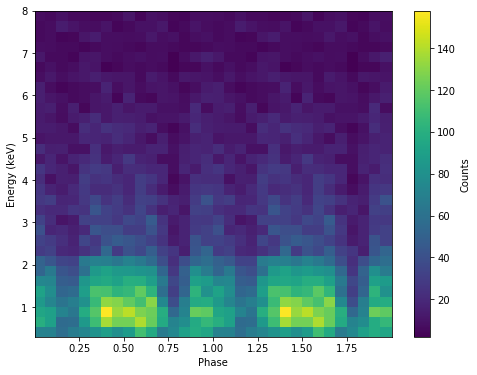

In [588]:
#repeating for epoch 3
#energy-phase without normalization
#need background as function of energy for these bins
plt.figure(figsize=(8,6)) 
ep3ph1 = ep3ph/compd
ep3ph2 = ep3ph1 + 1
ep3ph3 = list(ep3ph1)+list(ep3ph2)
ep3ed2 = list(ep3['PI'])+list(ep3['PI'])
ep3enhist = plt.hist2d(ep3ph3,np.array(ep3ed2)/100,bins=32) #convert from PI to keV
plt.colorbar(label='Counts')
plt.ylabel('Energy (keV)')
plt.xlabel('Phase')

In [589]:
#version with each row normalized
ep1norm = np.zeros((32,32))
for i in range(32):
    ep1norm[i,:] = ep1enhist[0][:,31-i]/np.median(ep1enhist[0][:,31-i])

### binning background for 32 energy bins

In [590]:
#background for 32 bins epoch1
ep1back = p.readevt(e1path+'back_epoch1-sun80-spaceweather.pha',ind=1)
ep1back = ep1back[ep1back['CHANNEL']>=30]
ep1back = ep1back[ep1back['CHANNEL']<=800]
ep1bc = np.array(ep1back['COUNTS'])
ep1enbg = np.zeros(32)
for i in range(32):
    ep1enbg[i] = np.sum(ep1bc[24*i:24*(i+1)])

In [591]:
#background for 32 bins epoch3
ep3back = p.readevt(e3path+'back_epoch3-sun80-spaceweather.pha',ind=1)
ep3back = ep3back[ep3back['CHANNEL']>=30]
ep3back = ep3back[ep3back['CHANNEL']<=800]
ep3bc = np.array(ep3back['COUNTS'])
ep3enbg = np.zeros(32)
for i in range(32):
    ep3enbg[i] = np.sum(ep3bc[24*i:24*(i+1)])

In [592]:
#divide by exposure time to get average
ep1enbg = ep1enbg/ep1time

In [593]:
#divide by exposure time to get average
ep3enbg = ep3enbg/ep3time

In [594]:
#version with each row normalized; bg-subtracted
#convert to count rate -- make sure corresponding
ep1norm_bg = np.zeros((32,32)) #16 phase bins
for i in range(32):
    ep1norm_bg[i,:] = ((ep1enhist[0][:,31-i]*16/ep1time)-ep1enbg[31-i]) 
    ep1norm_bg[i,:] = ep1norm_bg[i,:]/np.median(ep1norm_bg[i,:]) #16 phase bins

In [595]:
#version with each row normalized, for epoch 3
ep3norm = np.zeros((32,32))
for i in range(32):
    ep3norm[i,:] = ep3enhist[0][:,31-i]/np.median(ep3enhist[0][:,31-i])

In [596]:
#version with each row normalized; bg-subtracted
#convert to count rate -- make sure corresponding
ep3norm_bg = np.zeros((32,32)) #16 phase bins
for i in range(32):
    ep3norm_bg[i,:] = ((ep3enhist[0][:,31-i]*16/ep3time)-ep1enbg[31-i]) 
    ep3norm_bg[i,:] = ep3norm_bg[i,:]/np.median(ep3norm_bg[i,:]) #16 phase bins

Text(0, 0.5, 'Energy (0.3-8.0 keV)')

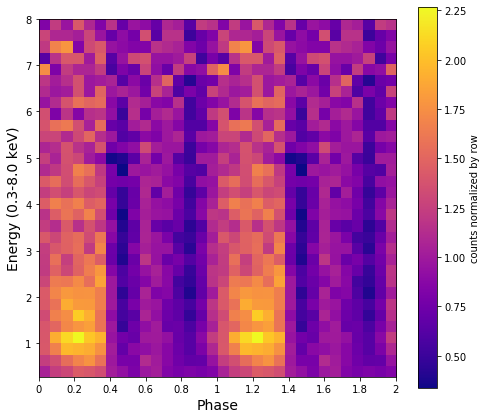

In [597]:
#epoch 1, no bg subtraction
plt.figure(figsize=(8,7))
plt.imshow(ep1norm,cmap='plasma')
plt.colorbar(label='counts normalized by row')
plt.yticks([28.5,28.5-32/7.7,28.5-2*32/7.7,28.5-3*32/7.7,28.5-4*32/7.7,28.5-5*32/7.7,28.5-6*32/7.7,28.5-7*32/7.7],[1,2,3,4,5,6,7,8])
plt.xticks([-0.5,2.7,6.4-.5,9.6-.5,12.8-.5,16-.5,19.2-.5,22.4-.5,25.6-.5,28.8-.5,31.5],[0,.2,.4,.6,.8,1,1.2,1.4,1.6,1.8,2])
plt.xlabel('Phase',fontsize=14)
plt.ylabel('Energy (0.3-8.0 keV)',fontsize=14)

Text(0, 0.5, 'Energy (0.3-8.0 keV)')

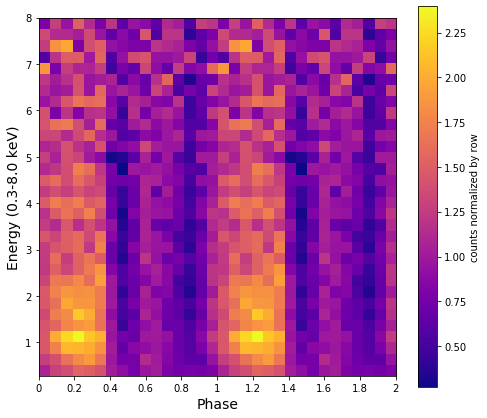

In [598]:
#epoch 1 bg-subtracted
plt.figure(figsize=(8,7))
plt.imshow(ep1norm_bg,cmap='plasma')
plt.colorbar(label='counts normalized by row')
plt.yticks([28.5,28.5-32/7.7,28.5-2*32/7.7,28.5-3*32/7.7,28.5-4*32/7.7,28.5-5*32/7.7,28.5-6*32/7.7,28.5-7*32/7.7],[1,2,3,4,5,6,7,8])
plt.xticks([-0.5,2.7,6.4-.5,9.6-.5,12.8-.5,16-.5,19.2-.5,22.4-.5,25.6-.5,28.8-.5,31.5],[0,.2,.4,.6,.8,1,1.2,1.4,1.6,1.8,2])
plt.xlabel('Phase',fontsize=14)
plt.ylabel('Energy (0.3-8.0 keV)',fontsize=14)

Text(0, 0.5, 'Energy (0.3-8.0 keV)')

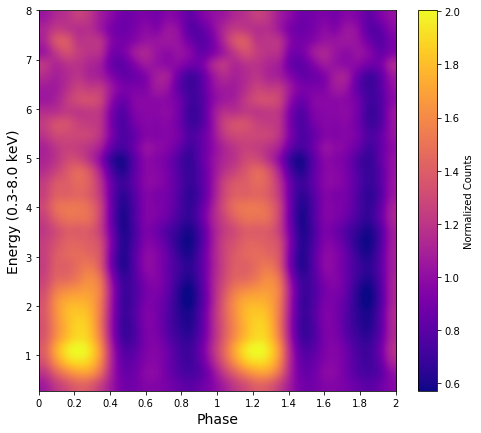

In [599]:
#smoothed, not bg-subtracted
plt.figure(figsize=(8,7))
ep1norm2=gaussian_filter(ep1norm, 0.8,mode='wrap')
im = plt.imshow(ep1norm2,cmap='plasma',interpolation='spline16',aspect='auto')
#plt.imshow(norm_bg,cmap='plasma',interpolation='gaussian')
plt.colorbar(label='Normalized Counts')
plt.yticks([28.5,28.5-32/7.7,28.5-2*32/7.7,28.5-3*32/7.7,28.5-4*32/7.7,28.5-5*32/7.7,28.5-6*32/7.7,28.5-7*32/7.7],[1,2,3,4,5,6,7,8])
plt.xticks([-0.5,2.7,6.4-.5,9.6-.5,12.8-.5,16-.5,19.2-.5,22.4-.5,25.6-.5,28.8-.5,31.5],[0,.2,.4,.6,.8,1,1.2,1.4,1.6,1.8,2])
plt.xlabel('Phase',fontsize=14)
plt.ylabel('Energy (0.3-8.0 keV)',fontsize=14)


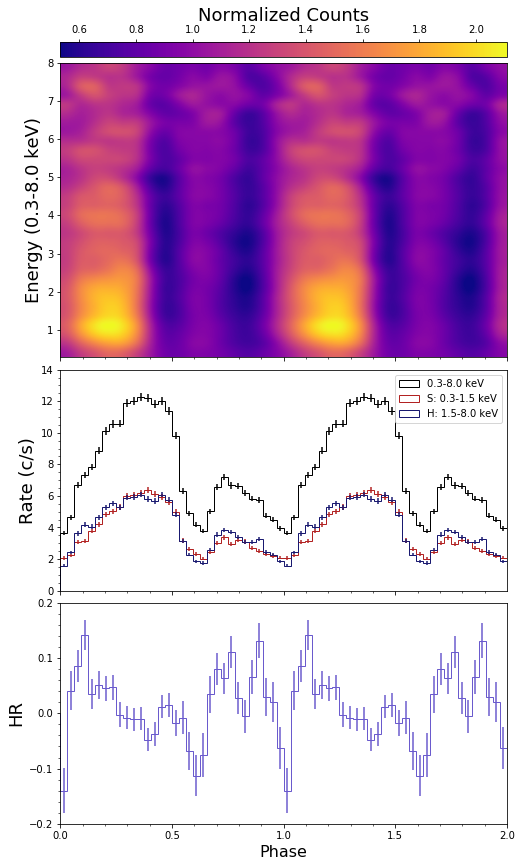

In [608]:
#heat map as middle panel with pulse profile and hardness ratios
#bg-subtracted
reload(p)
#32 phase bins (16 in "final" notebook)
ep1_3pan,ep1_3panerr = p.phaserate(ep1hists,ep1mids,ep1time,ens=['0.3-8.0 keV','S: 0.3-1.5 keV','H: 1.5-8.0 keV'],colors=['black','firebrick','midnightblue'],rate=True,figsize=(8,14),bgb=True,bg=ep1bg,enhist=True,ed=ep1,pd=pd,norm_bg=ep1norm_bg,yrange2=[-0.2,0.18])
sf('3Epoch/panelep1')


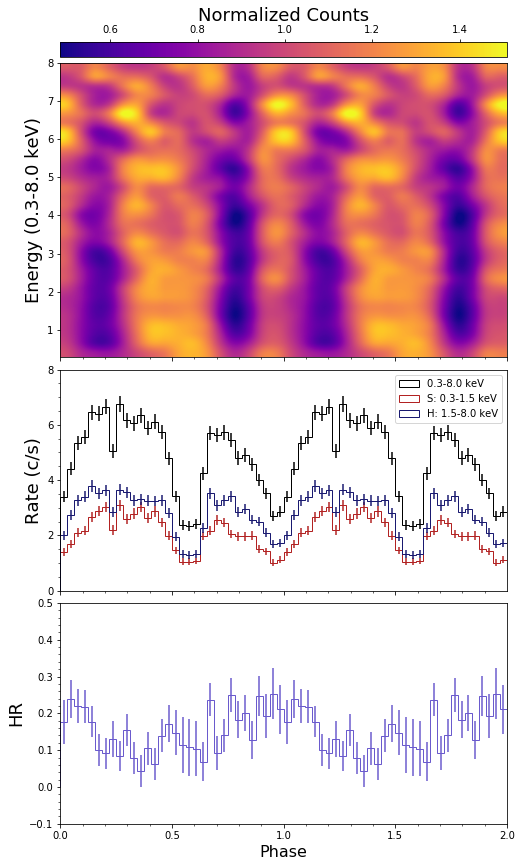

In [609]:
#for epoch 3; bg-subtracted
ep3_3pan,ep3_3panerr = p.phaserate(ep3hists,ep3mids,ep3time,ens=['0.3-8.0 keV','S: 0.3-1.5 keV','H: 1.5-8.0 keV'],colors=['black','firebrick','midnightblue'],
                               rate=True,figsize=(8,14),bgb=True,bg=ep3bg,enhist=True,ed=ep3,pd=compd,norm_bg=ep3norm_bg,yrange1=[0,7],yrange2=[-0.1,0.5])
sf('3Epoch/panelep3')


Text(0, 0.5, 'bg counts?')

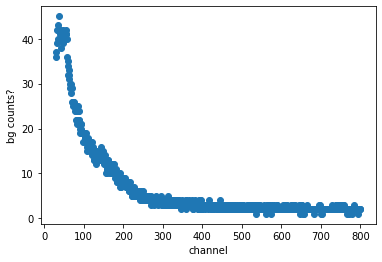

In [605]:
plt.scatter(ep1back['CHANNEL'],ep1back['COUNTS'])
plt.xlabel('channel')
plt.ylabel('bg counts?')


Text(0, 0.5, 'old bg')

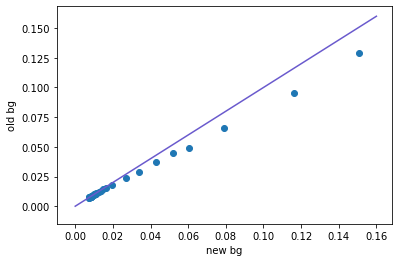

In [603]:
plt.scatter(ep1enbg,enbg[:,1])
lin = np.linspace(0,.16)
plt.plot(lin,lin,color='slateblue')
plt.xlabel('new bg')
plt.ylabel('old bg')

In [654]:
1/pd

0.01455985213471527

### HENdrics search new data


In [660]:
ep1ez=hendrics.io.load_folding(e1path+'epoch1-sun80-spaceweather_bar_nicer_xti_Z2n_0.01-0.02Hz.p')

INFO: Loading data and info from NIC_3ep/epoch1/epoch1-sun80-spaceweather_bar_nicer_xti_Z2n_0.01-0.02Hz.p [hendrics.io]


Text(0, 0.5, 'Z2n stat')

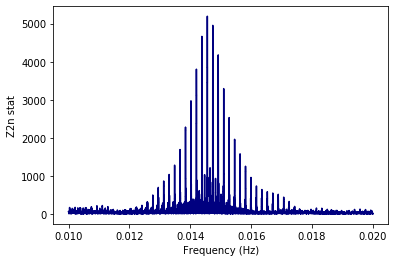

In [661]:
plt.plot(ep1ez.freq, ep1ez.stat, drawstyle='steps-mid',color='navy')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Z2n stat')

In [662]:
ep1p_res = pandas.DataFrame(columns=['freq','stat']) #zsearch result
ep1p_res['freq'] = ep1ez.freq
ep1p_res['stat'] = ep1ez.stat 
ep1p_res = ep1p_res.sort_values(by='stat',ascending=False)

In [665]:
ep1p_res['pd'] = 1/ep1p_res['freq']
ep1p_res[:10]

,freq,stat,pd
5869,0.014560,5194.213614,68.680222
5868,0.014559,5084.986207,68.683887
6099,0.014739,4954.207352,67.847469
6100,0.014740,4946.145084,67.843893
5870,0.014561,4718.773117,68.676557
5638,0.014381,4664.839327,69.537428
5637,0.014380,4476.464241,69.541185
5867,0.014559,4411.269073,68.687553
6101,0.014740,4384.909554,67.840316
6098,0.014738,4379.518727,67.851046


In [666]:
compd #new search on epoch3 gives 68.575

68.56842782790496

In [667]:
1/0.014582479681492322

68.57544271220019

In [671]:
ep3time

3014.9777161478996

In [672]:
pf2(ep1rateh[0][0],ep1errs[0])

0.5430191960549515+/-0.016122481934121916

In [673]:
pf2(ep3rateh[0][0],ep3errs[0])

0.4863726508917075+/-0.03331835972176964

In [674]:
print('min total rate: ',np.min(ep1rateh[0][0]),np.min(ep1errs[0]))
print('max total rate: ',np.max(ep1rateh[0][0]),np.max(ep1errs[0]))
print('mean total rate: ',np.mean(ep1rateh[0][0]))
print('total standard error', st.sem(ep1rateh[0][0]))

min total rate:  3.6391009689571305 0.14834967171055663
max total rate:  12.287611652410362 0.2546016767164825
mean total rate:  7.682415852019761
total standard error 0.3680121895339414


In [688]:
np.mean(len(ed)/exptime)

8.917641830839875

In [689]:
print('mean total rate: ',np.mean(ep3rateh[0][0]))
print('total standard error', st.sem(ep3rateh[0][0]))

mean total rate:  4.8693494221765645
total standard error 0.1702141327544352


In [687]:
print('original epoch 3 avg rate, not bg-sub',len(com)/comt)

print('new epoch 3 avg rate, not bg-sub',len(ep3)/ep3time)

# #using binning
# print('32 bin original epoch 3 avg rate, not bg-sub',np.mean(comh[0][0][0]))
# print('standard error',st.sem(comh[0][0][0]))


original epoch 3 avg rate, not bg-sub 4.995310547277241
new epoch 3 avg rate, not bg-sub 5.552279842846713


In [676]:
#error for com
np.sqrt(len(com))/comt

0.0327443450225533

In [692]:
compd

68.56842782790496

In [693]:
pd

68.68201618721699

# HR vs. time

- in the morning correct with count rate
- binning by time -- are the exposure intervals constant enough?

In [709]:
ep1[-1:]

TIME,RAWX,RAWY,PHA,PHA_FAST,DET_ID,DEADTIME,EVENT_FLAGS [8],TICK,MPU_A_TEMP,MPU_UNDER_COUNT,PI_FAST,PI,PI_RATIO
float64,uint8,uint8,int16,int16,uint8,float64,bool,int64,float64,int32,int16,int16,float32
203568012.80229336,4,1,2253,2020,26,2.2637299999999998e-05,False .. False,250221392336508,36.54759932000002,8,706,731,1.0354108


In [707]:
#soft and hard tables for epoch 1
e1s = ep1[ep1['PI']<=150]
e1h = ep1[ep1['PI']>150]

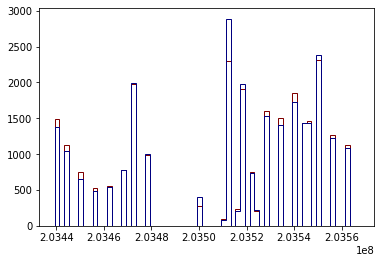

In [736]:
step2 = 2000

e1sb = plt.hist(e1s['TIME'],bins=np.arange(203439313,203568013,step2),histtype='step',color='maroon')
e1hb = plt.hist(e1h['TIME'],bins=np.arange(203439313,203568013,step2),histtype='step',color='navy')

In [737]:
e1hr = (e1hb[0]-e1sb[0])/(e1hb[0]+e1sb[0])
e1tot = e1hb[0]+e1sb[0]

In [738]:
len(e1hr)

64

Text(0, 0.5, 'HR')

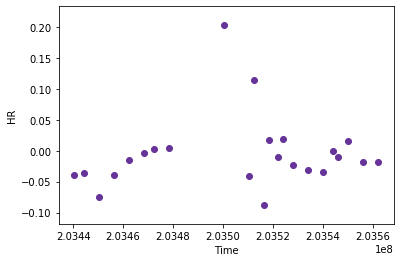

In [739]:
e1tb = np.arange(203439313+step2/2,203568013,step2)
plt.scatter(e1tb,e1hr,color='rebeccapurple')
plt.xlabel('Time')
plt.ylabel('HR')

Text(0, 0.5, 'Total Counts')

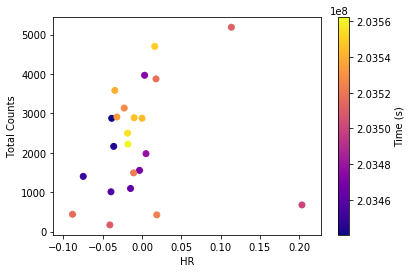

In [740]:

plt.scatter(e1hr,e1tot,c=e1tb,cmap='plasma')

plt.colorbar(label='Time (s)')
plt.xlabel('HR')
plt.ylabel('Total Counts') #harder when brighter for the most part

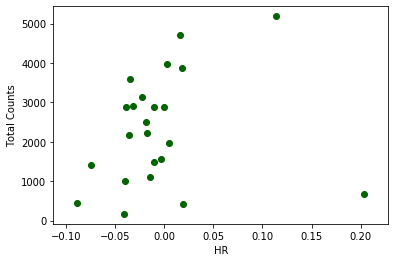

In [757]:
plt.scatter(e1hr,e1tot,color='darkgreen')

plt.xlabel('HR')
plt.ylabel('Total Counts') #harder when brighter for the most part
sf('countsHR')

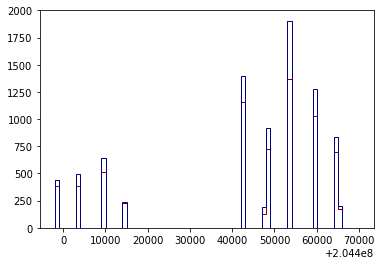

In [742]:
#repeat HR analysis for epoch 3
e3s = ep3[ep3['PI']<=150]
e3h = ep3[ep3['PI']>150]

step3 = 1000

e3sb = plt.hist(e3s['TIME'],bins=np.arange(204398031,204470678,step2),histtype='step',color='maroon')
e3hb = plt.hist(e3h['TIME'],bins=np.arange(204398031,204470678,step2),histtype='step',color='navy')

Text(0, 0.5, 'HR')

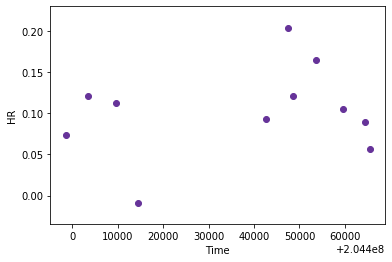

In [744]:
e3hr = (e3hb[0]-e3sb[0])/(e3hb[0]+e3sb[0])
e3tot = e3hb[0]+e3sb[0]
e3tb = np.arange(204398031+step3/2,204470678-step3,step3)
plt.scatter(e3tb,e3hr,color='rebeccapurple')
plt.xlabel('Time')
plt.ylabel('HR')

Text(0, 0.5, 'Total Counts')

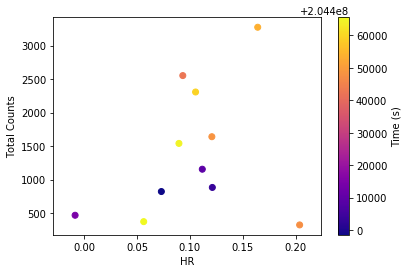

In [745]:
plt.scatter(e3hr,e3tot,c=e3tb,cmap='plasma')
plt.colorbar(label='Time (s)')
plt.xlabel('HR')
plt.ylabel('Total Counts') #harder when brighter for the most part

In [750]:
#can write more efficient function to bin by number of events

In [ ]:
tep1 = p.readevt(e1path+'epoch1-sun80-spaceweather_bar.evt',ind=2)
# tep1_nos = p.readevt(e1path+'epoch1-sun80.evt',ind=2)
# ep1_nos = p.readevt(e1path+'epoch1-sun80.evt')

# tep2 = p.readevt(e2path+'epoch2-sun80-spaceweather_bar.evt',ind=2)
# tep3 = p.readevt(e3path+'epoch3-sun80-spaceweather_bar.evt',ind=2)

In [753]:
len(tep1)

357

In [751]:
tep1[:5]

START,STOP
float64,float64
203439313.22464263,203439546.22521302
203439548.22521472,203439550.22521633
203439552.22521788,203439621.22523943
203439623.22523913,203439644.2252328
203439646.22523192,203439673.22521484


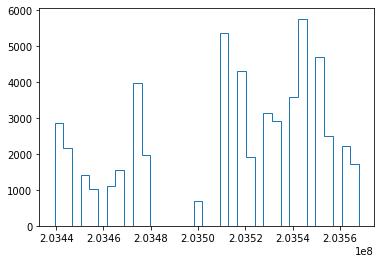

In [789]:
from astroML.plotting import hist
h1 = hist(ep1['TIME'], bins='knuth',histtype='step')

In [764]:
h1[1][21]-h1[1][20]

39.219664603471756

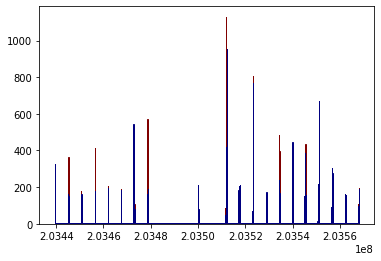

In [797]:
e1sbb = hist(e1s['TIME'],bins='blocks',histtype='step',color='maroon')
e1hbb = hist(e1h['TIME'],bins='blocks',histtype='step',color='navy')

In [791]:
e1hrb = (e1hbb[0]-e1sbb[0])/(e1hbb[0]+e1sbb[0])
e1totb = e1hbb[0]+e1sbb[0]

In [808]:
(t[-1]-t[0])/100

1286.9957604005933

In [803]:
bin_wid = e1hbb[1][1:]-e1hbb[1][:-1]


Text(0, 0.5, 'Total Counts')

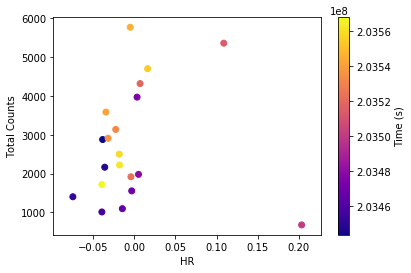

In [795]:
plt.scatter(e1hrk,e1totk,c=e1hbk[1][1:],cmap='plasma')

plt.colorbar(label='Time (s)')
plt.xlabel('HR')
plt.ylabel('Total Counts') #harder when brighter for the most part

In [806]:
import astropy.visualization.hist as bhist

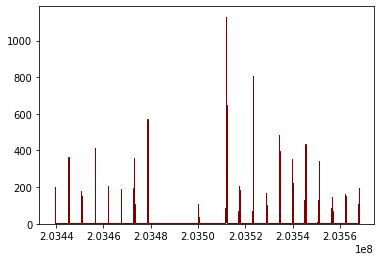

In [819]:
e1sbb = bhist(e1s['TIME'],bins='blocks',histtype='step',color='maroon')
#verify that bin bounds are the same for both
# e1hbb = bhist(e1h['TIME'],bins='blocks',histtype='step',color='navy',max_bins=300)

In [820]:
len(e1sbb[1])

294

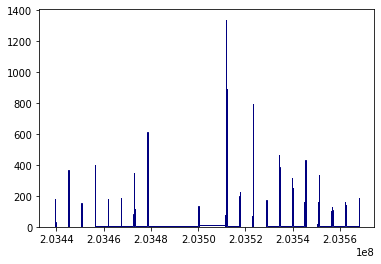

In [821]:
e1hbb = bhist(e1h['TIME'],bins=e1sbb[1],histtype='step',color='navy')

In [815]:
bin_wid = e1hbb[1][1:]-e1hbb[1][:-1]
#total width of bin

In [817]:
bin_wid[:5]

array([ 4.43137765, 45.84990442, 20.34653836, 46.12693295, 21.04274592])

In [825]:
bhr = (e1hbb[0]-e1sbb[0])/(e1hbb[0]+e1sbb[0])

In [826]:
totc = e1hbb[0]+e1sbb[0]

In [836]:
#average tim ein bin is first bound plus half the bin width 
bint = e1hbb[1][:-1]+(bin_wid/2)

In [837]:
#count rate for a bin is total counts divided by the bin width
totrat = totc/bin_wid

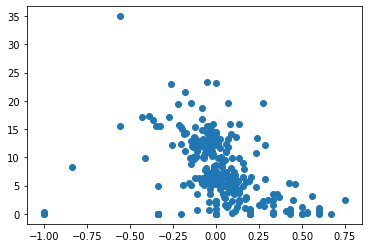

In [838]:
plt.scatter(bhr,totrat)

In [854]:
def hr_cr(soft,hard,blocks=True,bins=100):
    fig,ax = plt.subplots(1,2,figsize=(12,4))
    if blocks:
        sbb = bhist(soft['TIME'],bins='blocks',histtype='step',color='maroon',ax=ax[0])
    else:
        sbb = bhist(soft['TIME'],bins=bins,histtype='step',color='maroon',ax=ax[0])
    #use same bins used for soft
    hbb = bhist(hard['TIME'],bins=sbb[1],histtype='step',color='navy',ax=ax[0])
    #compute width (duration) of each bin
    bin_wid = hbb[1][1:]-hbb[1][:-1]
    #HR for each bin
    hr = (hbb[0]-sbb[0])/(hbb[0]+sbb[0])
    #total counts in each bin
    totc = hbb[0]+sbb[0]
    #average tim ein bin is first bound plus half the bin width 
    bint = hbb[1][:-1]+(bin_wid/2)
    #count rate using total counts and duration
    totrat = totc/bin_wid
    if blocks: ax[1].scatter(hr,totc,color='darkseagreen')
    else: ax[1].scatter(hr,totrat,color='darkseagreen')
    ax[1].set_xlabel('HR')
    ax[1].set_ylabel('Count Rate')

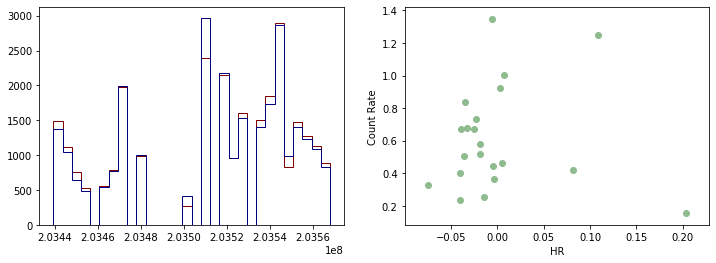

In [853]:
hr_cr(e1s,e1h,blocks=False,bins=30)

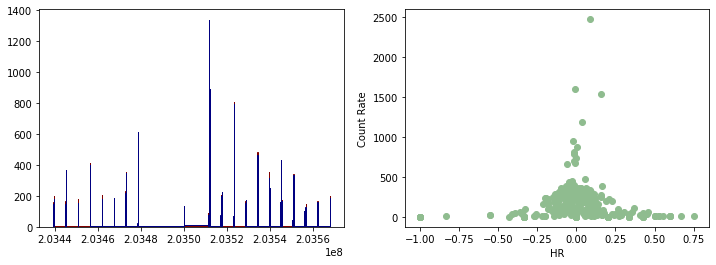

In [855]:
hr_cr(e1s,e1h) #y-axis is counts rather than count rate
#need to further correct

need efficient way to sort events into their gti!

In [861]:
timetest = np.array(tep1)

In [865]:
tep1[0]

START,STOP
float64,float64
203439313.22464263,203439546.22521302


In [866]:
timetest[:3]

array([(2.03439313e+08, 2.03439546e+08), (2.03439548e+08, 2.03439550e+08),
       (2.03439552e+08, 2.03439621e+08)],
      dtype=[('START', '<f8'), ('STOP', '<f8')])

In [868]:
tept = tep1['STOP']-tep1['START']
tept[0]

233.00057038664818

### start by using 357 bins of exposure time

In [871]:
tbins1 = np.array(tep1)
tbins1[:3]

array([(2.03439313e+08, 2.03439546e+08), (2.03439548e+08, 2.03439550e+08),
       (2.03439552e+08, 2.03439621e+08)],
      dtype=[('START', '<f8'), ('STOP', '<f8')])

In [879]:
tbins1 = np.concatenate((tep1['START'],tep1['STOP']))
tbins1 = np.sort(tbins1)
tbins1[:10]

array([2.03439313e+08, 2.03439546e+08, 2.03439548e+08, 2.03439550e+08,
       2.03439552e+08, 2.03439621e+08, 2.03439623e+08, 2.03439644e+08,
       2.03439646e+08, 2.03439673e+08])

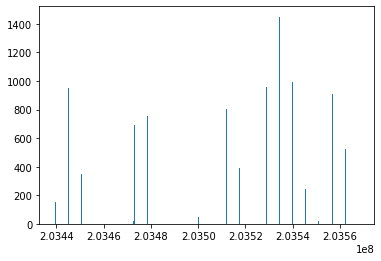

In [889]:
hist = plt.hist(e1s['TIME'],bins=list(tbins1))

In [894]:
#to do: make smaller bins by combining ones that are close in time; subtract that in-between time
def expbin(soft,hard,tep):
    fig,ax = plt.subplots(1,2,figsize=(12,4))
    tbins = np.concatenate((tep['START'],tep['STOP']))
    tbins = np.sort(tbins)
    sbb = bhist(soft['TIME'],bins=tbins,histtype='step',color='maroon',ax=ax[0],alpha=.4)
    #use same bins used for soft
    hbb = bhist(hard['TIME'],bins=tbins,histtype='step',color='navy',ax=ax[0],alpha=.4)
    #compute width (duration) of each bin
    bin_wid = hbb[1][1:]-hbb[1][:-1]
    #HR for each bin
    hr = (hbb[0]-sbb[0])/(hbb[0]+sbb[0])
    #total counts in each bin
    totc = hbb[0]+sbb[0]
    #average tim ein bin is first bound plus half the bin width 
    bint = hbb[1][:-1]+(bin_wid/2)
    #count rate using total counts and duration
    totrat = totc/bin_wid
#     ax[1].scatter(hr,totc,color='darkseagreen')
    ax[1].scatter(hr,totrat,color='darkseagreen')
    ax[1].set_xlabel('HR')
    ax[1].set_ylabel('Count Rate')
    return bin_wid

In [898]:
def expbin2(soft,hard,tep):
    '''Soft and hard histograms using binning of exposure time intervals'''
    tbins = np.concatenate((tep['START'],tep['STOP']))
    tbins = np.sort(tbins)
    sbb = bhist(soft['TIME'],bins=tbins,histtype='step',color='maroon',alpha=.4)
    #use same bins used for soft
    hbb = bhist(hard['TIME'],bins=tbins,histtype='step',color='navy',alpha=.4)
    
    return sbb,hbb

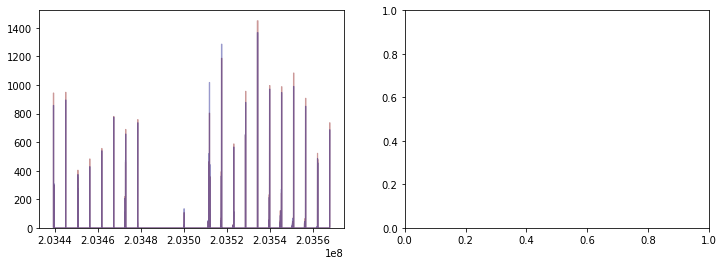

In [899]:
shi, hhi = expbin2(e1s,e1h,tep1)

In [1015]:
len(bin_wid)%4

1

In [1021]:
a = np.zeros(2)
a = np.concatenate((a,[3]))
a

array([0., 0., 3.])

In [1033]:
712/8

89.0

In [1054]:
def binmore(soft,hard,tep,n=2):
    '''Take output of expbin2 and bin further
    To do: use array_split which allows for splitting without equal division'''
    shi, hhi = expbin2(soft,hard,tep)
    bin_wid = shi[1][1:]-shi[1][:-1]
    #total counts in each bin
    #average tim ein bin is first bound plus half the bin width 
    bint = shi[1][:-1]+(bin_wid/2)
    scounts = shi[0]
    hcounts = hhi[0]
    if len(bin_wid)%(2*n) == 0: 
        #adding dummy number to allow for indexing of end
        bin_wid = np.concatenate((bin_wid,[0]))
        scounts = np.concatenate((scounts,[0]))
        hcounts = np.concatenate((hcounts,[0]))
        end = -1
    else: end = -1*(len(bin_wid)%(2*n))
    print(end)
    #when you get to high n, separately sum those cut-off contributions
    print(bin_wid.shape)
#     #first reshape to get bin widths that correspond to zeros
    bnw = np.reshape(bin_wid[:end],(np.int(len(bin_wid[:end])/2),2))
    bnw2 = bnw[:,0] #only keeps widths during exposures
    sco = np.reshape(scounts[:end],(np.int(len(scounts[:end])/(2*n)),2*n))
    hco = np.reshape(hcounts[:end],(np.int(len(hcounts[:end])/(2*n)),2*n))
    binw = np.reshape(bnw2,(np.int(len(bnw2)/n),n))
    
    sco2 = np.sum(sco,axis=1)
    hco2 = np.sum(hco,axis=1)
    binw2 = np.sum(binw,axis=1)
    
    ghr = (hco2-sco2)/(hco2+sco2) #to do: add errors, repeat for bin times
    #count rate
    gtot = hco2+sco2
    gcr = gtot/binw2
    
    plt.scatter(ghr,gcr,c=binw2)
    plt.xlabel('HR')
    plt.ylabel('CR')
    plt.colorbar(label='Exposure Time (s)') #color as bin width or tot counts gives similar answer
    return ghr,gtot,gcr

-33
(713,)


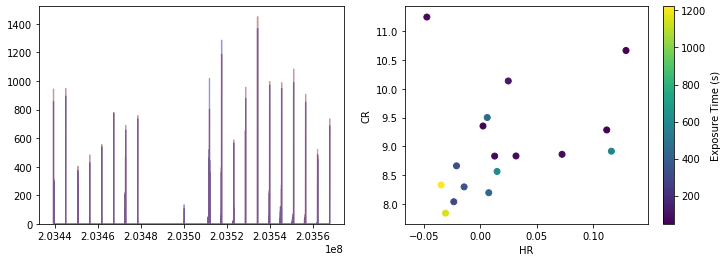

In [1055]:
ghr,gtot,gcr = binmore(e1s,e1h,tep1,n=20)

In [1108]:
def adaptbin(soft,hard,tep,n=2,cut=300):
    '''Less efficient, but get minimum of 300 second exposure time in each bin
    To do: add mean times and use for plotting'''
    shi, hhi = expbin2(soft,hard,tep)
    bin_wid = shi[1][1:]-shi[1][:-1]
    #total counts in each bin
    #average tim ein bin is first bound plus half the bin width 
    bint = shi[1][:-1]+(bin_wid/2)
    scounts = shi[0]
    hcounts = hhi[0]
    
    ind = 0 #switch start ind once 300 s exposure achieved each time
    chinds = [] #inds to start summing at
    if len(bin_wid)%2==0:
        bnw = np.reshape(bin_wid,(np.int(len(bin_wid)/2),2))
        sco = np.reshape(scounts,(np.int(len(scounts)/(2)),2))
        hco = np.reshape(hcounts,(np.int(len(hcounts)/(2)),2))
    else:
        bnw = np.reshape(bin_wid[:-1],(np.int(len(bin_wid[:-1])/2),2))
        sco = np.reshape(scounts[:-1],(np.int(len(scounts[:-1])/(2)),2))
        hco = np.reshape(hcounts[:-1],(np.int(len(hcounts[:-1])/(2)),2))
    bw = bnw[:,0] #only keeps widths during exposures
    sco = sco[:,0]
    hco = hco[:,0]
    sumt = 0
    expts = []
    #can change to do everything in one loop, but separated for now b/c of testing
    for i in range(len(bw)):
        sumt += bw[i]
        if sumt > cut:
            expts.append(sumt)
            sumt = 0 #reset to 0
            chinds.append(i+1)
    #soft subarrays
    ssubs = np.split(sco,chinds)
    hsubs = np.split(hco,chinds)
    bwsubs = np.split(bw,chinds)
    
    sbin = np.zeros(len(ssubs))
    hbin = np.zeros(len(ssubs))
    bwb = np.zeros(len(ssubs))
    for s in range(len(ssubs)):
        sbin[s]=np.sum(ssubs[s])
        hbin[s]=np.sum(hsubs[s])
        bwb[s]=np.sum(bwsubs[s])
    #version with error bars    
    serr=unumpy.uarray(sbin[:-1],np.sqrt(sbin[:-1])) #error is square root of counts
    herr=unumpy.uarray(hbin[:-1],np.sqrt(hbin[:-1]))
    ratio=(herr-serr)/(herr+serr)
           
    ghr = (hbin[:-1]-sbin[:-1])/(hbin[:-1]+sbin[:-1]) #to do: add errors, repeat for bin times
    #count rate
    gtot = hbin[:-1]+sbin[:-1]
    gterr = serr+herr
    gcr = gtot/bwb[:-1]
    gcrerr = gterr/bwb[:-1] #not sure of error on bin time
    #get errors on count rate and ratio
    rerr = np.zeros(len(serr))
    crerr = np.zeros(len(serr))
    for r in range(len(ratio)):
        rerr[r]=ratio[r].s #separates error 
        crerr[r]=gcrerr[r].s #separates error 
    plt.scatter(ghr,gcr,c=bwb[:-1])
    plt.errorbar(ghr,gcr,xerr=rerr,yerr=crerr,linestyle='none',alpha=.2,color='black')
    plt.xlabel('HR')
    plt.ylabel('CR')
    plt.colorbar(label='Exposure Time (s)') #color as bin width or tot counts gives similar answer
    return ghr,rerr,gtot,gcr,crerr


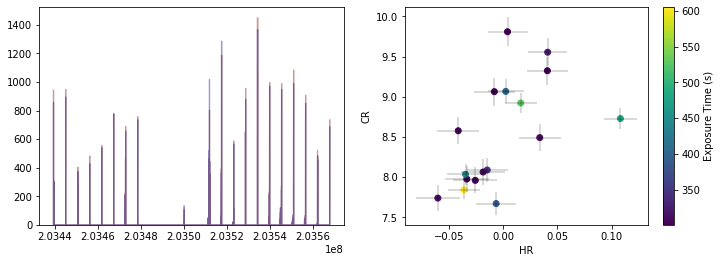

In [1117]:
ghr1,rerr1,gtot1,gcr1,crerr1 = adaptbin(e1s,e1h,tep1,cut=300)

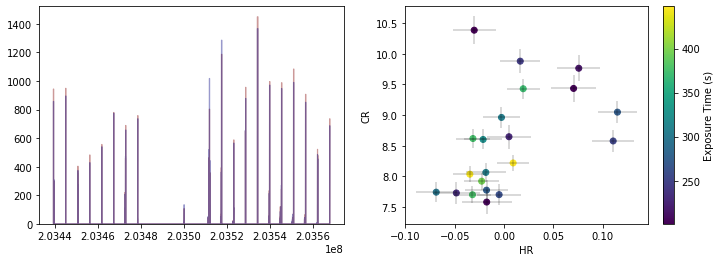

In [1118]:
ghr1_200,rerr1_200,gtot1_200,gcr1_200,crerr1_200 = adaptbin(e1s,e1h,tep1,cut=200)

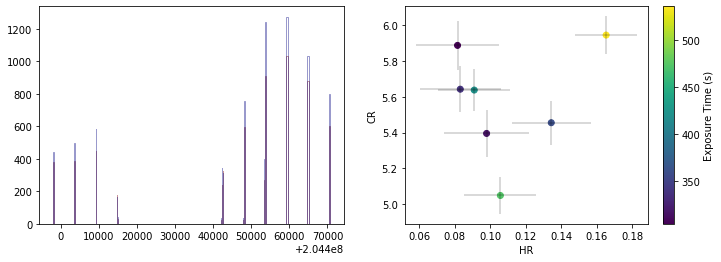

In [1111]:
ghr3,rerr3,gtot3,gcr3,crerr3 = adaptbin(e3s,e3h,tep3)

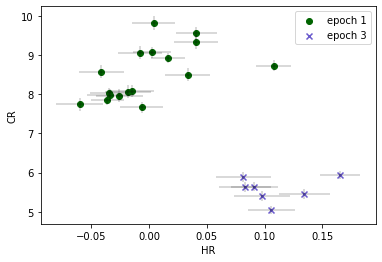

In [1114]:
plt.scatter(ghr1,gcr1,color='darkgreen',label='epoch 1')
plt.scatter(ghr3,gcr3,color='slateblue',marker='x',label='epoch 3')
plt.errorbar(ghr1,gcr1,xerr=rerr1,yerr=crerr1,linestyle='none',alpha=.2,color='black')
plt.errorbar(ghr3,gcr3,xerr=rerr3,yerr=crerr3,linestyle='none',alpha=.2,color='black')

plt.legend()
plt.xlabel('HR')
plt.ylabel('CR')
#add error bars
plt.savefig('CRHR.png',dpi=200,bbox_inches='tight')

In [1115]:
pwd

'/Users/lenatreiber/Desktop/Yale'

- effectively binning by exposure time and then changing number of bins to sum
- next step is to have adaptive summing, since we wind up with such different exposure times
--> i.e. once you get to 300 seconds of bin width, stop summing

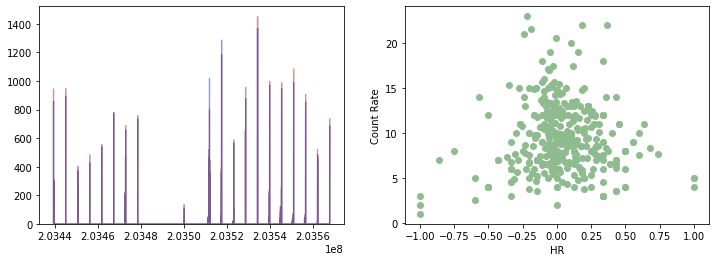

In [895]:
testbw = expbin(e1s,e1h,tep1)